
Training LSTM model...
Loaded existing model for LSTM from best_model_LSTM_3yr.pt
[LSTM] Epoch 100/1500, Training Loss: 0.000118, Validation Loss: 0.000363
Early stopping triggered
[LSTM] Early stopping at epoch 151
[LSTM] Test Loss: 0.000612
[LSTM] Test MAPE: 3.50%
[LSTM] Test Accuracy: 96.50%

Training GRU model...
Loaded existing model for GRU from best_model_GRU_3yr.pt
[GRU] Epoch 100/1500, Training Loss: 0.000093, Validation Loss: 0.000540
Early stopping triggered
[GRU] Early stopping at epoch 152
[GRU] Test Loss: 0.000686
[GRU] Test MAPE: 3.74%
[GRU] Test Accuracy: 96.26%

Training RNN model...
Loaded existing model for RNN from best_model_RNN_3yr.pt
[RNN] Epoch 100/1500, Training Loss: 0.000095, Validation Loss: 0.001602
[RNN] Epoch 200/1500, Training Loss: 0.000064, Validation Loss: 0.001774
Early stopping triggered
[RNN] Early stopping at epoch 240
[RNN] Test Loss: 0.005102
[RNN] Test MAPE: 11.67%
[RNN] Test Accuracy: 88.33%

Training CNN model...
Loaded existing model for CN

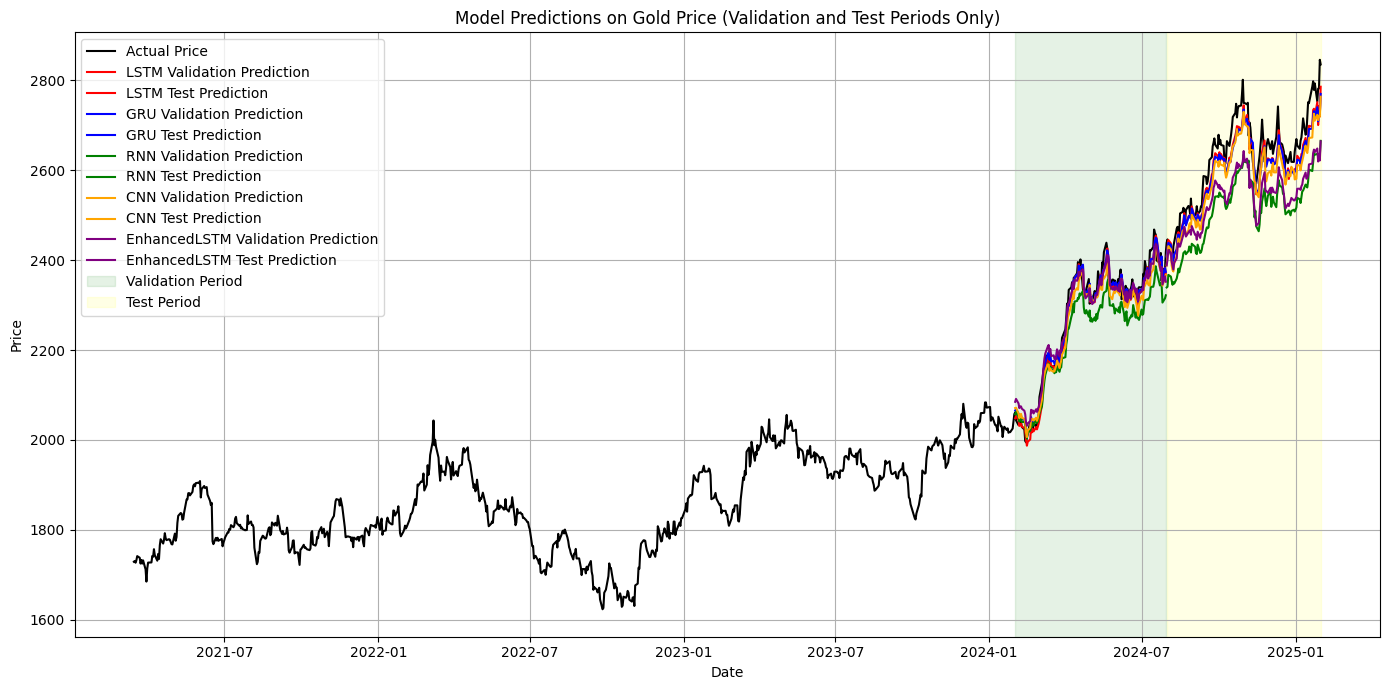

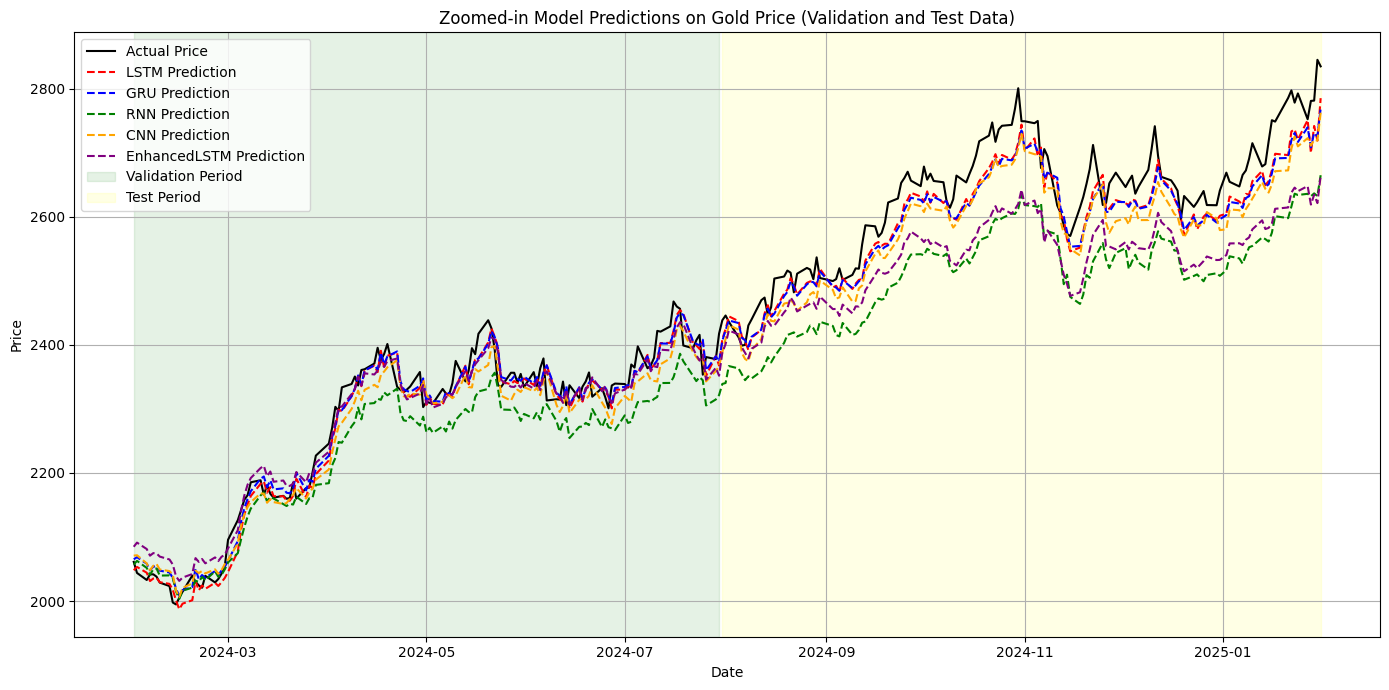

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # Ensure F is imported for activation functions
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import matplotlib.dates as mdates

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# Load and prepare data
df = pd.read_csv('Gold Futures Historical Data_3Yr.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Transform columns to numerical format
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True)
df[num_cols] = df[num_cols].astype('float64')

# Check for duplicates and nulls
assert df.duplicated().sum() == 0, "Duplicate rows found!"
assert df.isnull().sum().sum() == 0, "Missing values found!"

# Features to include
features = ['Price', 'Open', 'High', 'Low']
data = df[features].values

# Data scaling (scale each feature individually)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

### Window width ### Could be adjusted for experimentation ###
window_width = 30  # 30 days


# Prepare sequences and corresponding dates
X, y, dates = [], [], []
for i in range(window_width, len(data_scaled)):
    X.append(data_scaled[i - window_width:i])
    y.append(data_scaled[i, 0])  # Assuming 'Price' is the target
    dates.append(df['Date'].iloc[i])

X = np.array(X)
y = np.array(y)
dates = np.array(dates)

# Ensure that dates and y have the same length
assert len(dates) == len(y), "Mismatch between dates and y lengths"

# Split the data into training, validation, and test sets based on dates
train_mask = dates < pd.to_datetime('2024-02-01') 
val_mask = (dates >= pd.to_datetime('2024-02-01')) & (dates < pd.to_datetime('2024-07-31'))
test_mask = dates >= pd.to_datetime('2024-07-31')

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

train_dates = dates[train_mask]
val_dates = dates[val_mask]
test_dates = dates[test_mask]

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float().unsqueeze(1)
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 32  # Adjusted batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # Set shuffle=False for sequential data
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### All the above are the data cleaning and preparation steps ### 


# Define the models
class BaseModel(nn.Module):
    def __init__(self, model_type='LSTM'):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                nonlinearity='relu',
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'CNN':
            self.conv1 = nn.Conv1d(in_channels=len(features), out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            # Calculate the output size after Conv1d layers
            # Each Conv1d layer reduces the sequence length by (kernel_size - 1)
            conv_output_length = window_width - 2 * (3 - 1)  # Two Conv1d layers with kernel_size=3
            self.fc = nn.Linear(128 * conv_output_length, 1)
        elif model_type == 'EnhancedLSTM':
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=128,
                num_layers=3,
                batch_first=True,
                dropout=0.2,
            )
            self.dropout = nn.Dropout(0.2)
            self.bn = nn.BatchNorm1d(128)
            self.fc = nn.Linear(128, 1)
        else:
            raise ValueError("Invalid model_type. Choose 'LSTM', 'GRU', 'RNN', 'CNN', or 'EnhancedLSTM'.")

    def forward(self, x):
        if self.model_type == 'CNN':
            x = x.permute(0, 2, 1)  # Reshape for Conv1d: (batch_size, channels, seq_length)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type == 'EnhancedLSTM':
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        else:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        return out

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
            
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Define the inverse_transform function globally
def inverse_transform(y_scaled):
    """
    Inverse transform the scaled 'Price' values back to the original scale.
    Assumes that the scaler was fit on all features.
    """
    y_scaled = np.array(y_scaled).reshape(-1, 1)
    # Create a placeholder for other features with zeros
    zeros = np.zeros((y_scaled.shape[0], len(features) - 1))
    y_combined = np.hstack((y_scaled, zeros))
    y_inv = scaler.inverse_transform(y_combined)
    return y_inv[:, 0]

# Function to train and evaluate a model
def train_and_evaluate(model_name):
    # Initialize the model
    model = BaseModel(model_type=model_name).to(device)
    
    # Define the criterion, optimizer, and scheduler
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=150)
    
    # Early stopping
    early_stopping = EarlyStopping(patience=150, min_delta=0)
    num_epochs = 1500 # Adjusted number of epochs
    best_val_loss = float('inf')
    
    # Lists to store loss history
    train_losses_per_epoch = []
    val_losses_per_epoch = []
    
    # Path to save the best model checkpoint
    best_model_path = f'best_model_{model_name}_3yr.pt'
    
    # Check if a saved model exists and load it
    if os.path.exists(best_model_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            model.load_state_dict(torch.load(best_model_path, map_location=device))
        print(f"Loaded existing model for {model_name} from {best_model_path}")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        train_losses_per_epoch.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_losses = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                val_output = model(X_batch)
                val_loss = criterion(val_output, y_batch)
                val_losses.append(val_loss.item())
        avg_val_loss = np.mean(val_losses)
        val_losses_per_epoch.append(avg_val_loss)
        
        # Scheduler step
        scheduler.step(avg_val_loss)
        
        # Check for early stopping
        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print(f"[{model_name}] Early stopping at epoch {epoch + 1}")
            break
        
        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
        
        # Print losses every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f'[{model_name}] Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.6f}, Validation Loss: {avg_val_loss:.6f}')
    
    # Load the best model state
    model.load_state_dict(torch.load(best_model_path, weights_only=True))
    
    # Evaluate on test data
    model.eval()
    test_losses = []
    y_test_pred_list = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            test_losses.append(loss.item())
            y_test_pred_list.append(y_pred.cpu().numpy())
    avg_test_loss = np.mean(test_losses)
    print(f'[{model_name}] Test Loss: {avg_test_loss:.6f}')
    
    # Concatenate test predictions
    y_test_pred_array = np.concatenate(y_test_pred_list, axis=0)
    
    # Calculate MAPE and accuracy
    mape = mean_absolute_percentage_error(y_test_tensor.numpy(), y_test_pred_array)
    accuracy = 100 - mape * 100
    print(f'[{model_name}] Test MAPE: {mape * 100:.2f}%')
    print(f'[{model_name}] Test Accuracy: {accuracy:.2f}%')
    
    # Collect predictions over validation and test sets
    y_val_pred = []
    with torch.no_grad():
        for X_batch, _ in val_loader:
            X_batch = X_batch.to(device)
            y_pred_batch = model(X_batch)
            y_val_pred.append(y_pred_batch.cpu().numpy())
    y_val_pred = np.concatenate(y_val_pred, axis=0)
    
    y_test_pred = y_test_pred_array
    
    # Inverse scaling
    y_val_pred_inv = inverse_transform(y_val_pred)
    y_test_pred_inv = inverse_transform(y_test_pred)
    
    # Store results
    results = {
        'model_name': model_name,
        'val_dates': val_dates,
        'test_dates': test_dates,
        'y_val_pred_inv': y_val_pred_inv,
        'y_test_pred_inv': y_test_pred_inv,
        'train_losses_per_epoch': train_losses_per_epoch,
        'val_losses_per_epoch': val_losses_per_epoch,
    }
    
    return results

# List of models to train
model_names = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']

# Dictionary to store results
all_results = {}
    
# Train and evaluate each model
for model_name in model_names:
    print(f"\nTraining {model_name} model...")
    results = train_and_evaluate(model_name)
    all_results[model_name] = results

# Inverse transform the actual validation and test target values
y_val_inv = inverse_transform(y_val_tensor.numpy())
y_test_inv = inverse_transform(y_test_tensor.numpy())

# Colors for different models
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
    'EnhancedLSTM': 'purple',
}

# Plotting the full dataset with predictions over validation and test sets only
plt.figure(figsize=(14, 7))

# Actual Price
plt.plot(dates, inverse_transform(y), color='black', label='Actual Price')

# Plot predicted data for each model over validation and test datasets only
for model_name, results in all_results.items():
    # Plot validation predictions
    plt.plot(
        results['val_dates'],
        results['y_val_pred_inv'],
        color=model_colors[model_name],
        linestyle='-',
        label=f'{model_name} Validation Prediction'
    )
    # Plot test predictions
    plt.plot(
        results['test_dates'],
        results['y_test_pred_inv'],
        color=model_colors[model_name],
        linestyle='-',
        label=f'{model_name} Test Prediction'
    )

# Highlight validation and test periods
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')

plt.title('Model Predictions on Gold Price (Validation and Test Periods Only)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Zoomed-in plot for validation and test data with dashed lines for models
plt.figure(figsize=(14, 7))

# Combine validation and test dates and actual prices
zoom_dates = np.concatenate((val_dates, test_dates))
zoom_actual = np.concatenate((y_val_inv, y_test_inv))

# Plot actual prices for validation and test periods
plt.plot(
    zoom_dates,
    zoom_actual,
    color='black',
    label='Actual Price'
)

# Plot predicted data for each model during validation and test periods with dashed lines
for model_name, results in all_results.items():
    # Combine validation and test predictions
    y_pred_combined = np.concatenate((results['y_val_pred_inv'], results['y_test_pred_inv']))
    model_dates = np.concatenate((results['val_dates'], results['test_dates']))
    plt.plot(
        model_dates,
        y_pred_combined,
        color=model_colors[model_name],
        linestyle='--',  # Dashed lines
        label=f'{model_name} Prediction'
    )

# Highlight validation and test periods
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')

plt.title('Zoomed-in Model Predictions on Gold Price (Validation and Test Data)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




Training LSTM model...
Loaded existing model for LSTM from best_model_LSTM_3yr.pt
[LSTM] Epoch 100/1500, Training Loss: 0.000107, Validation Loss: 0.000622
Early stopping triggered
[LSTM] Early stopping at epoch 162
[LSTM] Test Loss: 0.001049
[LSTM] Test MAPE: 4.74%
[LSTM] Test Accuracy: 95.26%

Training GRU model...
Loaded existing model for GRU from best_model_GRU_3yr.pt


/tmp/ipykernel_1170596/763129605.py:311: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[GRU] Epoch 100/1500, Training Loss: 0.000097, Validation Loss: 0.000475
Early stopping triggered
[GRU] Early stopping at epoch 168
[GRU] Test Loss: 0.000572
[GRU] Test MAPE: 3.38%
[GRU] Test Accuracy: 96.62%

Training RNN model...
Loaded existing model for RNN from best_model_RNN_3yr.pt


/tmp/ipykernel_1170596/763129605.py:311: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[RNN] Epoch 100/1500, Training Loss: 0.000063, Validation Loss: 0.002368
Early stopping triggered
[RNN] Early stopping at epoch 188
[RNN] Test Loss: 0.005740
[RNN] Test MAPE: 12.45%
[RNN] Test Accuracy: 87.55%

Training CNN model...
Loaded existing model for CNN from best_model_CNN_3yr.pt


/tmp/ipykernel_1170596/763129605.py:311: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[CNN] Epoch 100/1500, Training Loss: 0.000076, Validation Loss: 0.001078
[CNN] Epoch 200/1500, Training Loss: 0.000070, Validation Loss: 0.001200
Early stopping triggered
[CNN] Early stopping at epoch 222
[CNN] Test Loss: 0.000459
[CNN] Test MAPE: 3.02%
[CNN] Test Accuracy: 96.98%

Training EnhancedLSTM model...
Loaded existing model for EnhancedLSTM from best_model_EnhancedLSTM_3yr.pt


/tmp/ipykernel_1170596/763129605.py:311: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[EnhancedLSTM] Epoch 100/1500, Training Loss: 0.003429, Validation Loss: 0.004041
[EnhancedLSTM] Epoch 200/1500, Training Loss: 0.003422, Validation Loss: 0.003518
[EnhancedLSTM] Epoch 300/1500, Training Loss: 0.003415, Validation Loss: 0.007291
Early stopping triggered
[EnhancedLSTM] Early stopping at epoch 345
[EnhancedLSTM] Test Loss: 0.004564
[EnhancedLSTM] Test MAPE: 10.22%
[EnhancedLSTM] Test Accuracy: 89.78%


/tmp/ipykernel_1170596/763129605.py:311: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


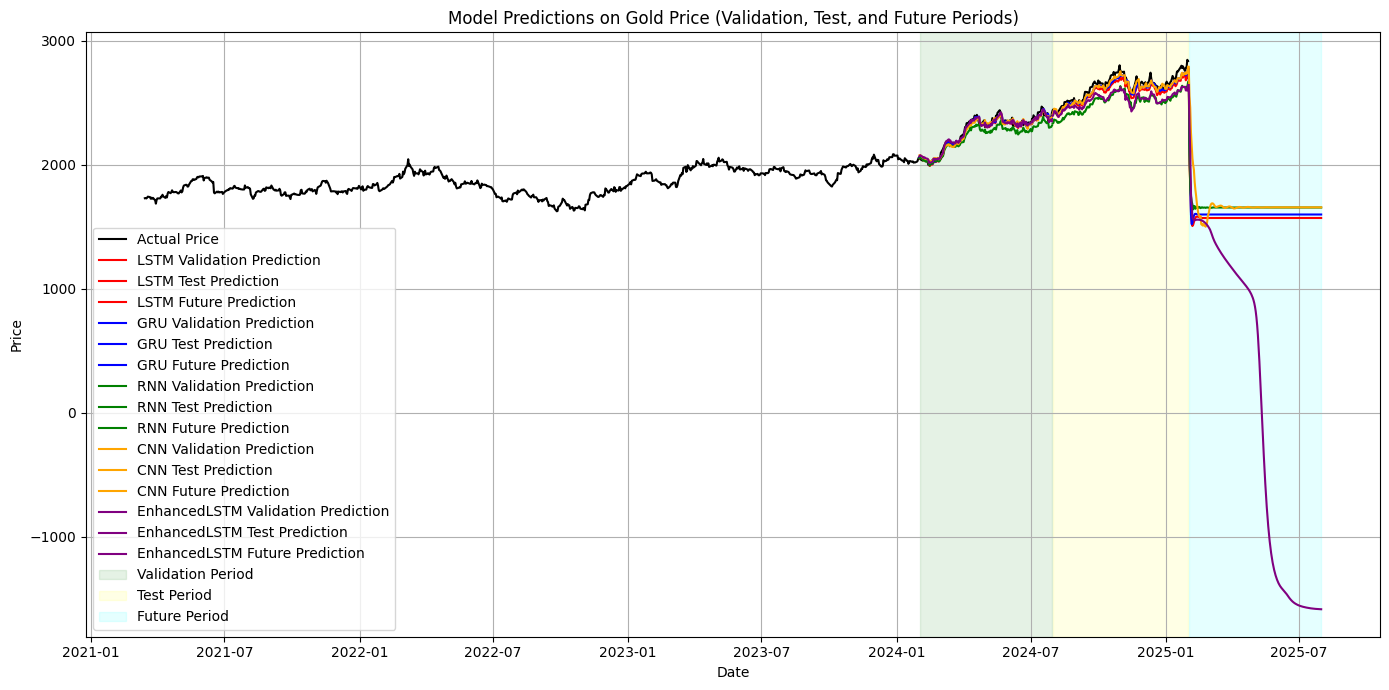

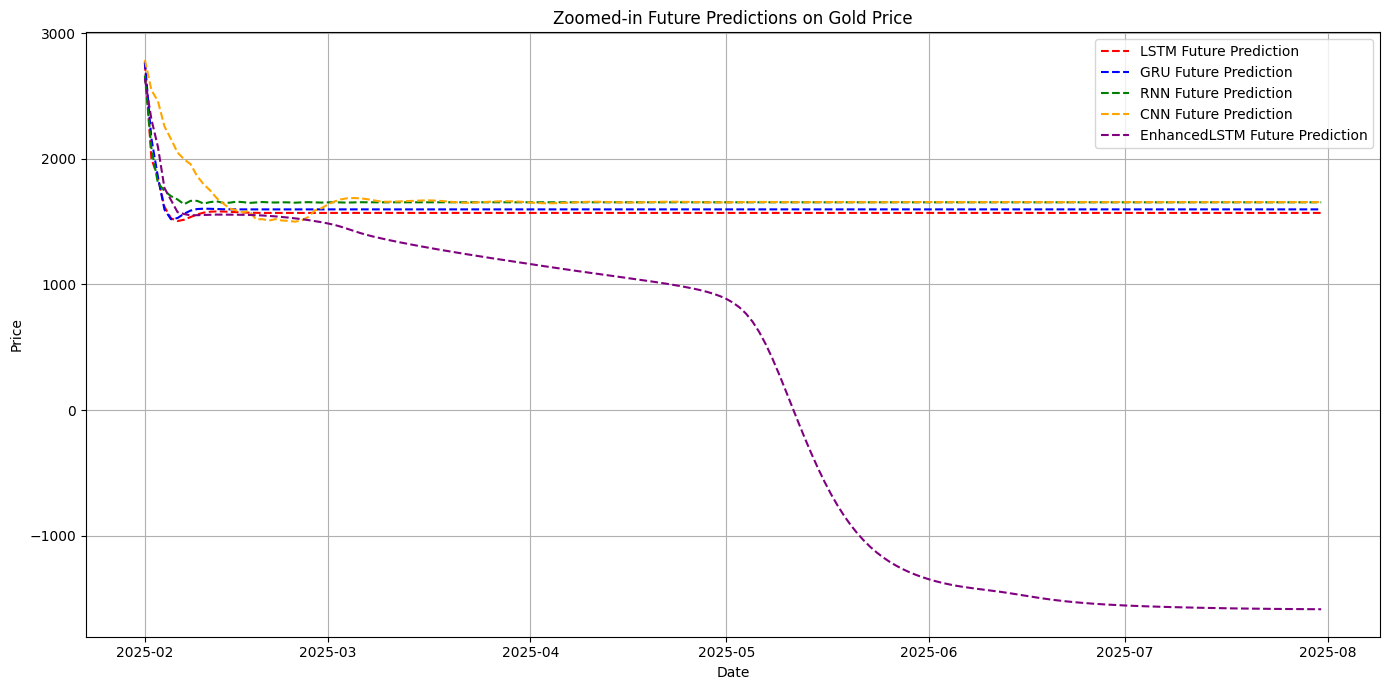

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # For activation functions
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import matplotlib.dates as mdates

# ------------------------------
# Set random seeds for reproducibility
# ------------------------------
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# ------------------------------
# Data Loading and Preparation
# ------------------------------
df = pd.read_csv('Gold Futures Historical Data_3Yr.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Transform numeric columns
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True)
df[num_cols] = df[num_cols].astype('float64')

# Check for duplicates and nulls
assert df.duplicated().sum() == 0, "Duplicate rows found!"
assert df.isnull().sum().sum() == 0, "Missing values found!"

# Define features and target
features = ['Price', 'Open', 'High', 'Low']
data = df[features].values

# Scale the data (each feature individually)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# ------------------------------
# Create Sequences (Sliding Window)
# ------------------------------
window_width = 30  # 30 days window

X, y, dates = [], [], []
for i in range(window_width, len(data_scaled)):
    X.append(data_scaled[i - window_width:i])
    y.append(data_scaled[i, 0])  # 'Price' is the target
    dates.append(df['Date'].iloc[i])

X = np.array(X)
y = np.array(y)
dates = np.array(dates)

assert len(dates) == len(y), "Mismatch between dates and y lengths"

# ------------------------------
# Split Data: Training, Validation, and Test
# ------------------------------
train_mask = dates < pd.to_datetime('2024-02-01')
val_mask = (dates >= pd.to_datetime('2024-02-01')) & (dates < pd.to_datetime('2024-07-31'))
test_mask = dates >= pd.to_datetime('2024-07-31')

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

train_dates = dates[train_mask]
val_dates = dates[val_mask]
test_dates = dates[test_mask]

# ------------------------------
# Convert Data to PyTorch Tensors and Create DataLoaders
# ------------------------------
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float().unsqueeze(1)
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # sequential data
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------------------------------
# Define the Model
# ------------------------------
class BaseModel(nn.Module):
    def __init__(self, model_type='LSTM'):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                nonlinearity='relu',
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'CNN':
            self.conv1 = nn.Conv1d(in_channels=len(features), out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            # Calculate output length after two Conv1d layers (each reduces length by kernel_size-1)
            conv_output_length = window_width - 2 * (3 - 1)
            self.fc = nn.Linear(128 * conv_output_length, 1)
        elif model_type == 'EnhancedLSTM':
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=128,
                num_layers=3,
                batch_first=True,
                dropout=0.2,
            )
            self.dropout = nn.Dropout(0.2)
            self.bn = nn.BatchNorm1d(128)
            self.fc = nn.Linear(128, 1)
        else:
            raise ValueError("Invalid model_type. Choose 'LSTM', 'GRU', 'RNN', 'CNN', or 'EnhancedLSTM'.")
    
    def forward(self, x):
        if self.model_type == 'CNN':
            # For CNN, rearrange dimensions: (batch, channels, sequence_length)
            x = x.permute(0, 2, 1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type == 'EnhancedLSTM':
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        else:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        return out

# ------------------------------
# Define Early Stopping
# ------------------------------
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# ------------------------------
# Inverse Transform Function
# ------------------------------
def inverse_transform(y_scaled):
    """
    Inverse transform the scaled 'Price' values back to the original scale.
    Assumes the scaler was fit on all features.
    """
    y_scaled = np.array(y_scaled).reshape(-1, 1)
    # Create placeholders for other features (set to zero)
    zeros = np.zeros((y_scaled.shape[0], len(features) - 1))
    y_combined = np.hstack((y_scaled, zeros))
    y_inv = scaler.inverse_transform(y_combined)
    return y_inv[:, 0]

# ------------------------------
# Helper: Generate Future Predictions
# ------------------------------
def generate_future_predictions(model, last_window, num_days):
    """
    Recursively generate future predictions using the last known window.
    After each prediction, update the window (drop the oldest, add the new prediction).
    """
    model.eval()
    current_window = last_window.copy()  # shape: (window_width, num_features)
    future_preds = []
    for i in range(num_days):
        # Prepare input (reshape to [1, window_width, num_features])
        input_tensor = torch.from_numpy(current_window).float().unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(input_tensor)
        pred_value = pred.cpu().numpy()[0, 0]  # scaled prediction
        future_preds.append(pred_value)
        # Create a new row with predicted Price and zeros for other features
        new_row = np.zeros(current_window.shape[1])
        new_row[0] = pred_value
        # Update window: drop first row and append new prediction
        current_window = np.vstack([current_window[1:], new_row])
    return np.array(future_preds)

# ------------------------------
# Train and Evaluate Function (Includes Future Predictions)
# ------------------------------
def train_and_evaluate(model_name):
    # Initialize model and send it to device
    model = BaseModel(model_type=model_name).to(device)
    
    # Define loss, optimizer, and learning rate scheduler
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=150)
    
    early_stopping = EarlyStopping(patience=150, min_delta=0)
    num_epochs = 1500
    best_val_loss = float('inf')
    
    train_losses_per_epoch = []
    val_losses_per_epoch = []
    
    best_model_path = f'best_model_{model_name}_3yr.pt'
    
    # Load an existing model if available
    if os.path.exists(best_model_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            model.load_state_dict(torch.load(best_model_path, map_location=device))
        print(f"Loaded existing model for {model_name} from {best_model_path}")
    
    # Training Loop
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        train_losses_per_epoch.append(avg_train_loss)
        
        # Validation Phase
        model.eval()
        val_losses = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                val_output = model(X_batch)
                val_loss = criterion(val_output, y_batch)
                val_losses.append(val_loss.item())
        avg_val_loss = np.mean(val_losses)
        val_losses_per_epoch.append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print(f"[{model_name}] Early stopping at epoch {epoch + 1}")
            break
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
        
        if (epoch + 1) % 100 == 0:
            print(f'[{model_name}] Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.6f}, Validation Loss: {avg_val_loss:.6f}')
    
    # Load the best model weights
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    
    # ------------------------------
    # Evaluate on Test Data
    # ------------------------------
    model.eval()
    test_losses = []
    y_test_pred_list = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            test_losses.append(loss.item())
            y_test_pred_list.append(y_pred.cpu().numpy())
    avg_test_loss = np.mean(test_losses)
    print(f'[{model_name}] Test Loss: {avg_test_loss:.6f}')
    
    y_test_pred_array = np.concatenate(y_test_pred_list, axis=0)
    mape = mean_absolute_percentage_error(y_test_tensor.numpy(), y_test_pred_array)
    accuracy = 100 - mape * 100
    print(f'[{model_name}] Test MAPE: {mape * 100:.2f}%')
    print(f'[{model_name}] Test Accuracy: {accuracy:.2f}%')
    
    # ------------------------------
    # Get Predictions on Validation Set
    # ------------------------------
    y_val_pred = []
    with torch.no_grad():
        for X_batch, _ in val_loader:
            X_batch = X_batch.to(device)
            y_pred_batch = model(X_batch)
            y_val_pred.append(y_pred_batch.cpu().numpy())
    y_val_pred = np.concatenate(y_val_pred, axis=0)
    
    # Inverse transform predictions to original scale
    y_val_pred_inv = inverse_transform(y_val_pred)
    y_test_pred_inv = inverse_transform(y_test_pred_array)
    
    # ------------------------------
    # Generate Future Predictions
    # ------------------------------
    future_dates = pd.date_range(start='2025-02-01', end='2025-07-31', freq='D')
    num_future_days = len(future_dates)
    last_window = X[-1]  # Use the last window from the entire dataset
    future_preds_scaled = generate_future_predictions(model, last_window, num_future_days)
    future_preds_inv = inverse_transform(future_preds_scaled)
    
    results = {
        'model_name': model_name,
        'val_dates': val_dates,
        'test_dates': test_dates,
        'future_dates': future_dates,
        'y_val_pred_inv': y_val_pred_inv,
        'y_test_pred_inv': y_test_pred_inv,
        'future_pred_inv': future_preds_inv,
        'train_losses_per_epoch': train_losses_per_epoch,
        'val_losses_per_epoch': val_losses_per_epoch,
    }
    return results

# ------------------------------
# Train and Evaluate All Models
# ------------------------------
model_names = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']
all_results = {}
for model_name in model_names:
    print(f"\nTraining {model_name} model...")
    results = train_and_evaluate(model_name)
    all_results[model_name] = results

# ------------------------------
# Inverse Transform Actual Prices for Plotting
# ------------------------------
y_val_inv = inverse_transform(y_val_tensor.numpy())
y_test_inv = inverse_transform(y_test_tensor.numpy())

# Define colors for plotting
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
    'EnhancedLSTM': 'purple',
}

# ------------------------------
# Plot: Actual Price and Model Predictions (Validation, Test, and Future)
# ------------------------------
plt.figure(figsize=(14, 7))
plt.plot(dates, inverse_transform(y), color='black', label='Actual Price')

for model_name, results in all_results.items():
    # Plot Validation Predictions
    plt.plot(
        results['val_dates'],
        results['y_val_pred_inv'],
        color=model_colors[model_name],
        linestyle='-',
        label=f'{model_name} Validation Prediction'
    )
    # Plot Test Predictions
    plt.plot(
        results['test_dates'],
        results['y_test_pred_inv'],
        color=model_colors[model_name],
        linestyle='-',
        label=f'{model_name} Test Prediction'
    )
    # Plot Future Predictions
    plt.plot(
        results['future_dates'],
        results['future_pred_inv'],
        color=model_colors[model_name],
        linestyle='-',
        label=f'{model_name} Future Prediction'
    )

# Highlight the periods
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')
plt.axvspan(pd.to_datetime('2025-02-01'), pd.to_datetime('2025-07-31'), color='cyan', alpha=0.1, label='Future Period')

plt.title('Model Predictions on Gold Price (Validation, Test, and Future Periods)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------
# Optional: Zoomed-in Plot for Future Predictions
# ------------------------------
plt.figure(figsize=(14, 7))
for model_name, results in all_results.items():
    plt.plot(
        results['future_dates'],
        results['future_pred_inv'],
        color=model_colors[model_name],
        linestyle='--',
        label=f'{model_name} Future Prediction'
    )
plt.title('Zoomed-in Future Predictions on Gold Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Training LSTM model...
Loaded existing model for LSTM from best_model_LSTM_3yr.pt
[LSTM] Epoch 100/1500, Training Loss: 0.000099, Validation Loss: 0.001162
Early stopping triggered
[LSTM] Early stopping at epoch 165
[LSTM] Test Loss: 0.000488
[LSTM] Test MAPE: 3.05%
[LSTM] Test Accuracy: 96.95%

Training GRU model...
Loaded existing model for GRU from best_model_GRU_3yr.pt


/tmp/ipykernel_1170596/682390302.py:317: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[GRU] Epoch 100/1500, Training Loss: 0.000089, Validation Loss: 0.000586
Early stopping triggered
[GRU] Early stopping at epoch 151
[GRU] Test Loss: 0.000299
[GRU] Test MAPE: 2.36%
[GRU] Test Accuracy: 97.64%

Training RNN model...
Loaded existing model for RNN from best_model_RNN_3yr.pt


/tmp/ipykernel_1170596/682390302.py:317: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[RNN] Epoch 100/1500, Training Loss: 0.000055, Validation Loss: 0.003050
Early stopping triggered
[RNN] Early stopping at epoch 151
[RNN] Test Loss: 0.006464
[RNN] Test MAPE: 13.25%
[RNN] Test Accuracy: 86.75%

Training CNN model...
Loaded existing model for CNN from best_model_CNN_3yr.pt


/tmp/ipykernel_1170596/682390302.py:317: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[CNN] Epoch 100/1500, Training Loss: 0.000090, Validation Loss: 0.001806
[CNN] Epoch 200/1500, Training Loss: 0.000091, Validation Loss: 0.001866
Early stopping triggered
[CNN] Early stopping at epoch 277
[CNN] Test Loss: 0.001101
[CNN] Test MAPE: 4.93%
[CNN] Test Accuracy: 95.07%

Training EnhancedLSTM model...
Loaded existing model for EnhancedLSTM from best_model_EnhancedLSTM_3yr.pt


/tmp/ipykernel_1170596/682390302.py:317: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[EnhancedLSTM] Epoch 100/1500, Training Loss: 0.003409, Validation Loss: 0.003215
Early stopping triggered
[EnhancedLSTM] Early stopping at epoch 187
[EnhancedLSTM] Test Loss: 0.011150
[EnhancedLSTM] Test MAPE: 16.80%
[EnhancedLSTM] Test Accuracy: 83.20%


/tmp/ipykernel_1170596/682390302.py:317: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


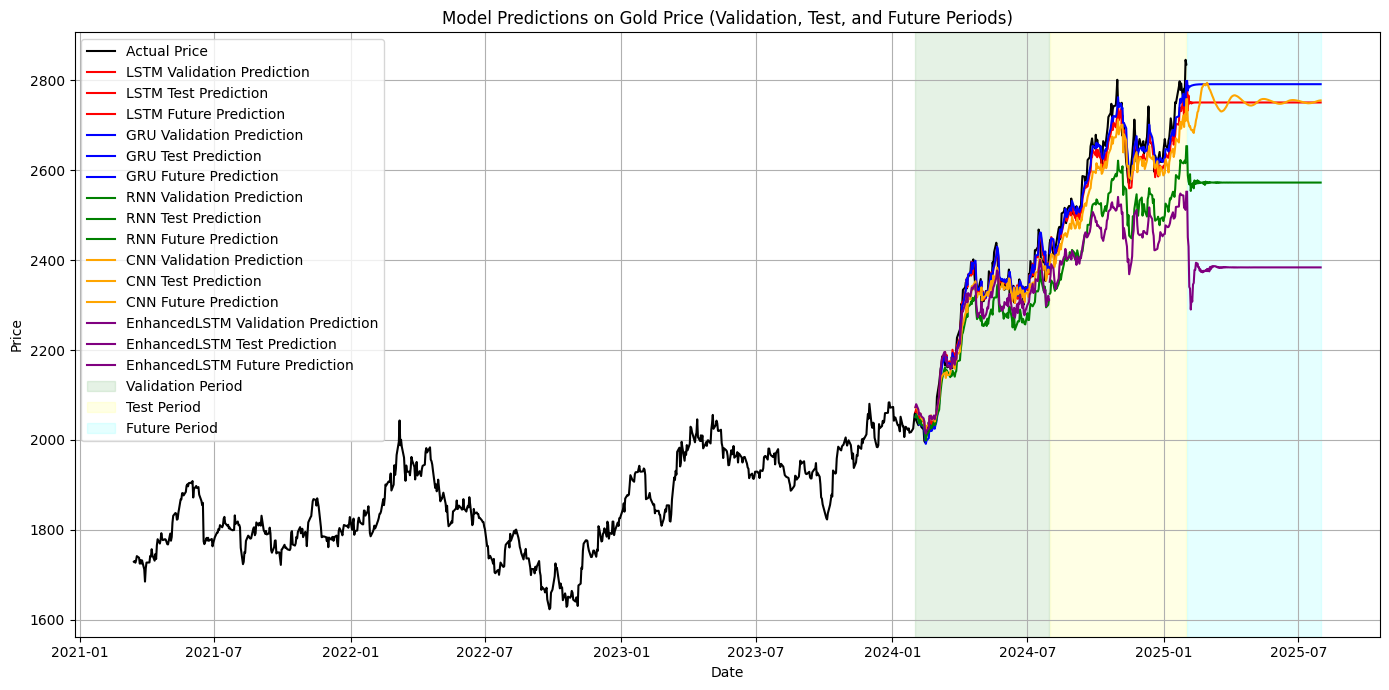

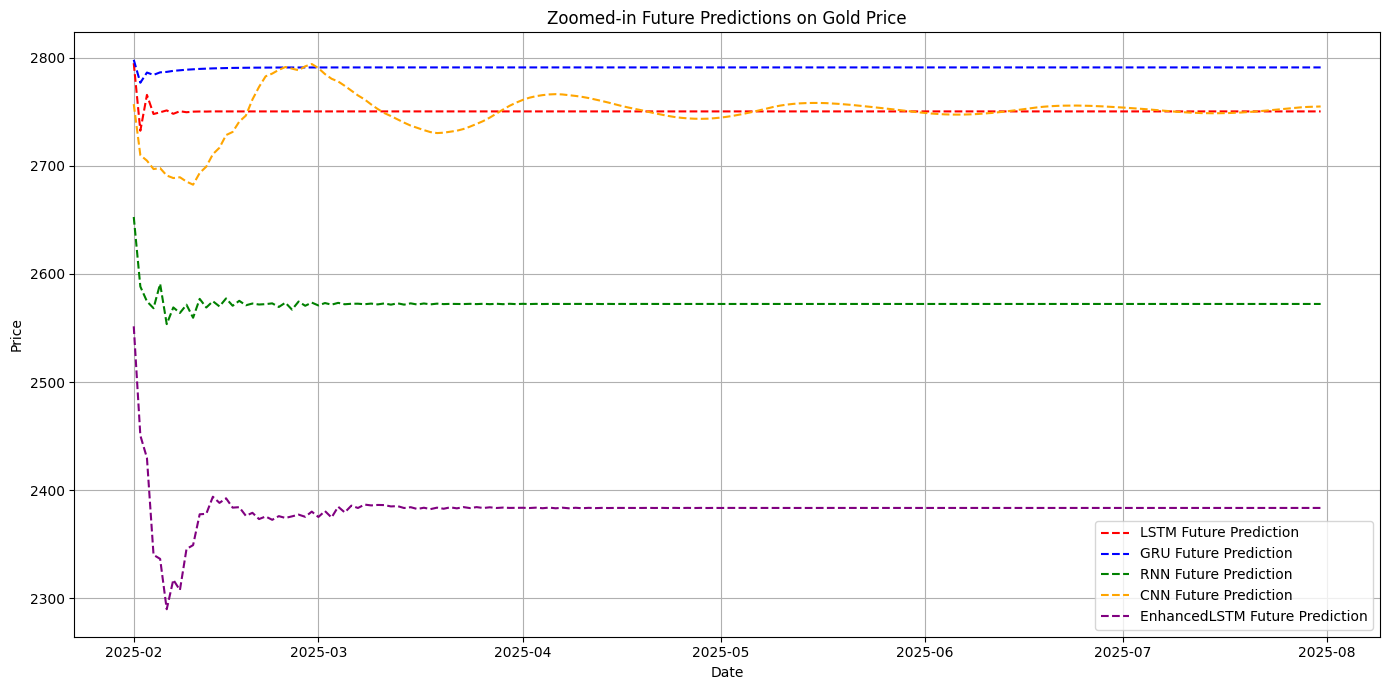

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # For activation functions
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import matplotlib.dates as mdates

# ------------------------------
# Set random seeds for reproducibility
# ------------------------------
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# ------------------------------
# Data Loading and Preparation
# ------------------------------
df = pd.read_csv('Gold Futures Historical Data_3Yr.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Transform numeric columns
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True)
df[num_cols] = df[num_cols].astype('float64')

# Check for duplicates and nulls
assert df.duplicated().sum() == 0, "Duplicate rows found!"
assert df.isnull().sum().sum() == 0, "Missing values found!"

# Define features and target
features = ['Price', 'Open', 'High', 'Low']
data = df[features].values

# Scale the data (each feature individually)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# ------------------------------
# Create Sequences (Sliding Window)
# ------------------------------
window_width = 30  # 30-day window

X, y, dates = [], [], []
for i in range(window_width, len(data_scaled)):
    X.append(data_scaled[i - window_width:i])
    y.append(data_scaled[i, 0])  # 'Price' is the target
    dates.append(df['Date'].iloc[i])

X = np.array(X)
y = np.array(y)
dates = np.array(dates)

assert len(dates) == len(y), "Mismatch between dates and y lengths"

# ------------------------------
# Split Data: Training, Validation, and Test
# ------------------------------
train_mask = dates < pd.to_datetime('2024-02-01')
val_mask = (dates >= pd.to_datetime('2024-02-01')) & (dates < pd.to_datetime('2024-07-31'))
test_mask = dates >= pd.to_datetime('2024-07-31')

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

train_dates = dates[train_mask]
val_dates = dates[val_mask]
test_dates = dates[test_mask]

# ------------------------------
# Convert Data to PyTorch Tensors and Create DataLoaders
# ------------------------------
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float().unsqueeze(1)
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # Sequential data
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------------------------------
# Define the Model
# ------------------------------
class BaseModel(nn.Module):
    def __init__(self, model_type='LSTM'):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                nonlinearity='relu',
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'CNN':
            self.conv1 = nn.Conv1d(in_channels=len(features), out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            conv_output_length = window_width - 2 * (3 - 1)  # after two conv layers
            self.fc = nn.Linear(128 * conv_output_length, 1)
        elif model_type == 'EnhancedLSTM':
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=128,
                num_layers=3,
                batch_first=True,
                dropout=0.2,
            )
            self.dropout = nn.Dropout(0.2)
            self.bn = nn.BatchNorm1d(128)
            self.fc = nn.Linear(128, 1)
        else:
            raise ValueError("Invalid model_type. Choose 'LSTM', 'GRU', 'RNN', 'CNN', or 'EnhancedLSTM'.")
    
    def forward(self, x):
        if self.model_type == 'CNN':
            x = x.permute(0, 2, 1)  # reshape for Conv1d: (batch, channels, sequence_length)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type == 'EnhancedLSTM':
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        else:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        return out

# ------------------------------
# Define Early Stopping
# ------------------------------
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# ------------------------------
# Inverse Transform Function
# ------------------------------
def inverse_transform(y_scaled):
    """
    Inverse transform the scaled 'Price' values back to the original scale.
    Assumes that the scaler was fit on all features.
    """
    y_scaled = np.array(y_scaled).reshape(-1, 1)
    zeros = np.zeros((y_scaled.shape[0], len(features) - 1))
    y_combined = np.hstack((y_scaled, zeros))
    y_inv = scaler.inverse_transform(y_combined)
    return y_inv[:, 0]

# ------------------------------
# Helper: Generate Future Predictions
# ------------------------------
def generate_future_predictions(model, last_window, num_days, use_last_window_features=True):
    """
    Recursively generate future predictions using the last known window.
    
    For each prediction:
      - The model receives an input window.
      - The Price prediction is obtained.
      - If use_last_window_features is True, the new row is created by taking the last row
        of the current window (which carries realistic variations for Open, High, Low) and
        replacing the Price with the predicted value.
      - Otherwise, non-target features are set to zero.
    """
    model.eval()
    current_window = last_window.copy()  # shape: (window_width, num_features)
    future_preds = []
    for i in range(num_days):
        input_tensor = torch.from_numpy(current_window).float().unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(input_tensor)
        pred_value = pred.cpu().numpy()[0, 0]  # scaled prediction
        future_preds.append(pred_value)
        if use_last_window_features:
            # Use the non-target features from the last row of current_window.
            new_row = current_window[-1].copy()
            new_row[0] = pred_value
        else:
            # If not, set non-target features to zero.
            new_row = np.zeros(current_window.shape[1])
            new_row[0] = pred_value
        current_window = np.vstack([current_window[1:], new_row])
    return np.array(future_preds)

# ------------------------------
# Train and Evaluate Function (Including Future Predictions)
# ------------------------------
def train_and_evaluate(model_name):
    # Initialize model and send it to device
    model = BaseModel(model_type=model_name).to(device)
    
    # Define loss, optimizer, and scheduler
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=150)
    
    early_stopping = EarlyStopping(patience=150, min_delta=0)
    num_epochs = 1500
    best_val_loss = float('inf')
    
    train_losses_per_epoch = []
    val_losses_per_epoch = []
    
    best_model_path = f'best_model_{model_name}_3yr.pt'
    
    if os.path.exists(best_model_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            model.load_state_dict(torch.load(best_model_path, map_location=device))
        print(f"Loaded existing model for {model_name} from {best_model_path}")
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        train_losses_per_epoch.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_losses = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                val_output = model(X_batch)
                val_loss = criterion(val_output, y_batch)
                val_losses.append(val_loss.item())
        avg_val_loss = np.mean(val_losses)
        val_losses_per_epoch.append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print(f"[{model_name}] Early stopping at epoch {epoch + 1}")
            break
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
        
        if (epoch + 1) % 100 == 0:
            print(f'[{model_name}] Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.6f}, Validation Loss: {avg_val_loss:.6f}')
    
    # Load the best model weights
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    
    # ------------------------------
    # Evaluate on Test Data
    # ------------------------------
    model.eval()
    test_losses = []
    y_test_pred_list = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            test_losses.append(loss.item())
            y_test_pred_list.append(y_pred.cpu().numpy())
    avg_test_loss = np.mean(test_losses)
    print(f'[{model_name}] Test Loss: {avg_test_loss:.6f}')
    
    y_test_pred_array = np.concatenate(y_test_pred_list, axis=0)
    mape = mean_absolute_percentage_error(y_test_tensor.numpy(), y_test_pred_array)
    accuracy = 100 - mape * 100
    print(f'[{model_name}] Test MAPE: {mape * 100:.2f}%')
    print(f'[{model_name}] Test Accuracy: {accuracy:.2f}%')
    
    # ------------------------------
    # Get Predictions on Validation Set
    # ------------------------------
    y_val_pred = []
    with torch.no_grad():
        for X_batch, _ in val_loader:
            X_batch = X_batch.to(device)
            y_pred_batch = model(X_batch)
            y_val_pred.append(y_pred_batch.cpu().numpy())
    y_val_pred = np.concatenate(y_val_pred, axis=0)
    
    y_val_pred_inv = inverse_transform(y_val_pred)
    y_test_pred_inv = inverse_transform(y_test_pred_array)
    
    # ------------------------------
    # Generate Future Predictions
    # ------------------------------
    future_dates = pd.date_range(start='2025-02-01', end='2025-07-31', freq='D')
    num_future_days = len(future_dates)
    # Use the last window from the entire dataset as the seed
    last_window = X[-1]
    # Set use_last_window_features=True to carry forward non-target features
    future_preds_scaled = generate_future_predictions(model, last_window, num_future_days, use_last_window_features=True)
    future_preds_inv = inverse_transform(future_preds_scaled)
    
    results = {
        'model_name': model_name,
        'val_dates': val_dates,
        'test_dates': test_dates,
        'future_dates': future_dates,
        'y_val_pred_inv': y_val_pred_inv,
        'y_test_pred_inv': y_test_pred_inv,
        'future_pred_inv': future_preds_inv,
        'train_losses_per_epoch': train_losses_per_epoch,
        'val_losses_per_epoch': val_losses_per_epoch,
    }
    return results

# ------------------------------
# Train and Evaluate All Models
# ------------------------------
model_names = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']
all_results = {}
for model_name in model_names:
    print(f"\nTraining {model_name} model...")
    results = train_and_evaluate(model_name)
    all_results[model_name] = results

# ------------------------------
# Inverse Transform Actual Prices for Plotting
# ------------------------------
y_val_inv = inverse_transform(y_val_tensor.numpy())
y_test_inv = inverse_transform(y_test_tensor.numpy())

# Define colors for plotting
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
    'EnhancedLSTM': 'purple',
}

# ------------------------------
# Plot: Actual Price and Model Predictions (Validation, Test, and Future)
# ------------------------------
plt.figure(figsize=(14, 7))
plt.plot(dates, inverse_transform(y), color='black', label='Actual Price')

for model_name, results in all_results.items():
    # Plot Validation Predictions
    plt.plot(
        results['val_dates'],
        results['y_val_pred_inv'],
        color=model_colors[model_name],
        linestyle='-',
        label=f'{model_name} Validation Prediction'
    )
    # Plot Test Predictions
    plt.plot(
        results['test_dates'],
        results['y_test_pred_inv'],
        color=model_colors[model_name],
        linestyle='-',
        label=f'{model_name} Test Prediction'
    )
    # Plot Future Predictions
    plt.plot(
        results['future_dates'],
        results['future_pred_inv'],
        color=model_colors[model_name],
        linestyle='-',
        label=f'{model_name} Future Prediction'
    )

# Highlight the periods
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')
plt.axvspan(pd.to_datetime('2025-02-01'), pd.to_datetime('2025-07-31'), color='cyan', alpha=0.1, label='Future Period')

plt.title('Model Predictions on Gold Price (Validation, Test, and Future Periods)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------
# Optional: Zoomed-in Plot for Future Predictions
# ------------------------------
plt.figure(figsize=(14, 7))
for model_name, results in all_results.items():
    plt.plot(
        results['future_dates'],
        results['future_pred_inv'],
        color=model_colors[model_name],
        linestyle='--',
        label=f'{model_name} Future Prediction'
    )
plt.title('Zoomed-in Future Predictions on Gold Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Training LSTM model...
Loaded existing model for LSTM from best_model_LSTM_3yr.pt
[LSTM] Epoch 100/1500, Training Loss: 0.000014
[LSTM] Epoch 200/1500, Training Loss: 0.000022
[LSTM] Epoch 300/1500, Training Loss: 0.000008
Early stopping triggered
[LSTM] Early stopping at epoch 399


/tmp/ipykernel_1170596/1751649855.py:313: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[LSTM] Online Recursive Forecast - Validation MAPE: 15.96%
[LSTM] Online Recursive Forecast - Test MAPE: 7.72%

Training GRU model...
Loaded existing model for GRU from best_model_GRU_3yr.pt
[GRU] Epoch 100/1500, Training Loss: 0.000010
[GRU] Epoch 200/1500, Training Loss: 0.000010
Early stopping triggered
[GRU] Early stopping at epoch 273


/tmp/ipykernel_1170596/1751649855.py:313: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[GRU] Online Recursive Forecast - Validation MAPE: 8.61%
[GRU] Online Recursive Forecast - Test MAPE: 5.11%

Training RNN model...
Loaded existing model for RNN from best_model_RNN_3yr.pt
[RNN] Epoch 100/1500, Training Loss: 0.000019
[RNN] Epoch 200/1500, Training Loss: 0.000016
[RNN] Epoch 300/1500, Training Loss: 0.000037
[RNN] Epoch 400/1500, Training Loss: 0.000016
[RNN] Epoch 500/1500, Training Loss: 0.000020
Early stopping triggered
[RNN] Early stopping at epoch 595


/tmp/ipykernel_1170596/1751649855.py:313: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[RNN] Online Recursive Forecast - Validation MAPE: 9.20%
[RNN] Online Recursive Forecast - Test MAPE: 6.55%

Training CNN model...
Loaded existing model for CNN from best_model_CNN_3yr.pt
[CNN] Epoch 100/1500, Training Loss: 0.000065
Early stopping triggered
[CNN] Early stopping at epoch 198


/tmp/ipykernel_1170596/1751649855.py:313: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[CNN] Online Recursive Forecast - Validation MAPE: 9.62%
[CNN] Online Recursive Forecast - Test MAPE: 6.45%

Training EnhancedLSTM model...
Loaded existing model for EnhancedLSTM from best_model_EnhancedLSTM_3yr.pt
[EnhancedLSTM] Epoch 100/1500, Training Loss: 0.003407
[EnhancedLSTM] Epoch 200/1500, Training Loss: 0.003363
[EnhancedLSTM] Epoch 300/1500, Training Loss: 0.003357
Early stopping triggered
[EnhancedLSTM] Early stopping at epoch 326


/tmp/ipykernel_1170596/1751649855.py:313: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[EnhancedLSTM] Online Recursive Forecast - Validation MAPE: 57.91%
[EnhancedLSTM] Online Recursive Forecast - Test MAPE: 90.61%


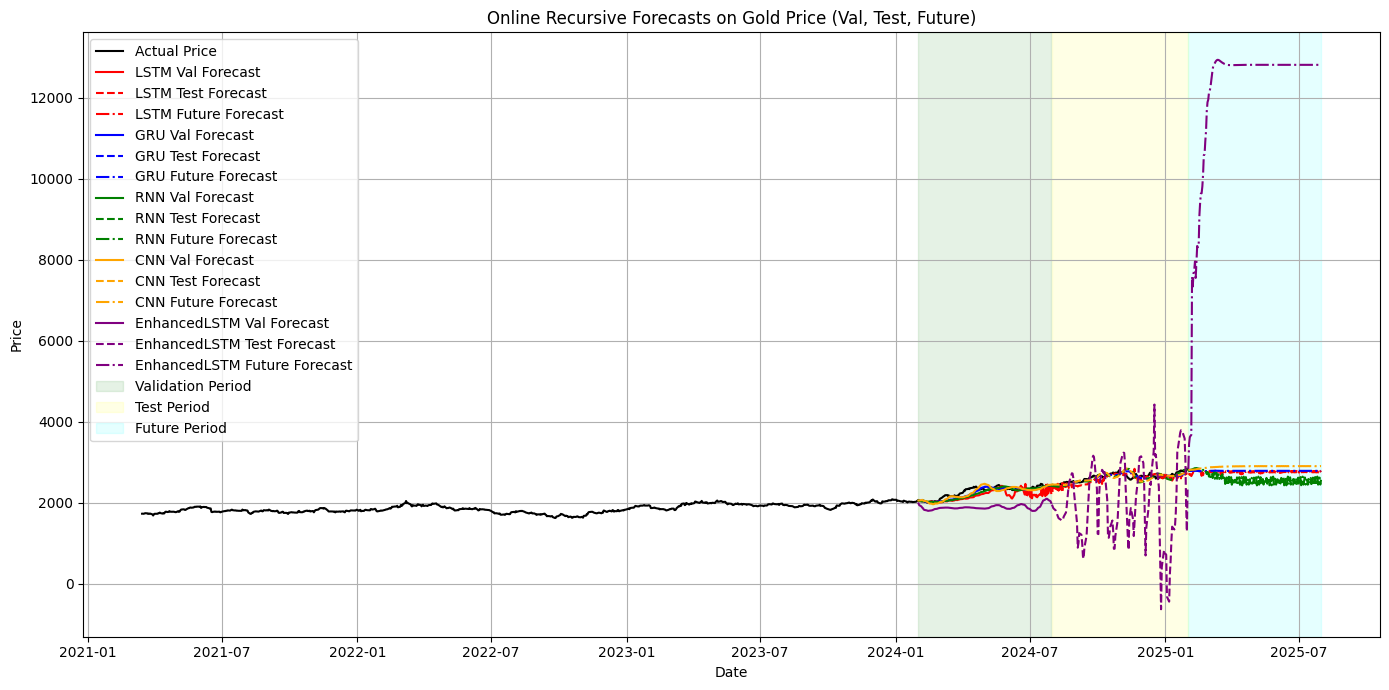

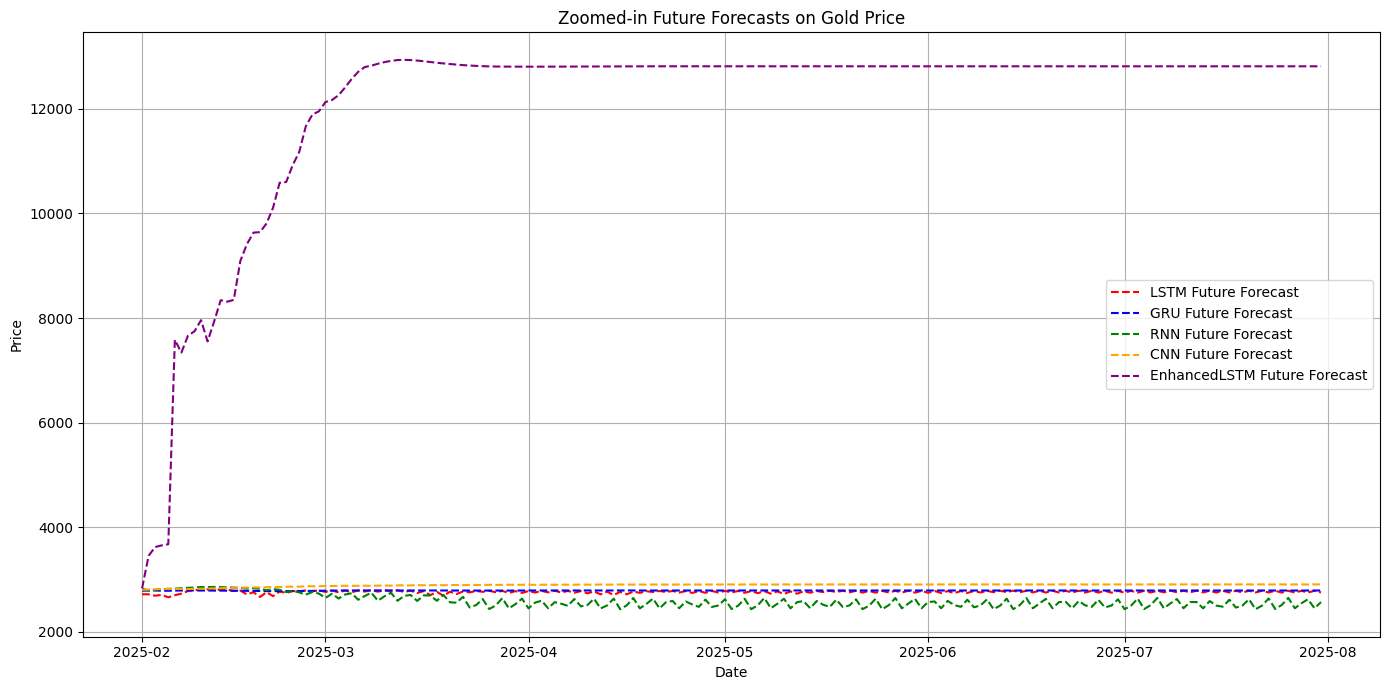

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # For activation functions
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import matplotlib.dates as mdates

# ------------------------------
# Set random seeds for reproducibility
# ------------------------------
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# ------------------------------
# Data Loading and Preparation
# ------------------------------
df = pd.read_csv('Gold Futures Historical Data_3Yr.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Convert numeric columns
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True)
df[num_cols] = df[num_cols].astype('float64')

assert df.duplicated().sum() == 0, "Duplicate rows found!"
assert df.isnull().sum().sum() == 0, "Missing values found!"

# ------------------------------
# Define features and scale data
# ------------------------------
features = ['Price', 'Open', 'High', 'Low']
data = df[features].values

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# ------------------------------
# Create Sequences using a Sliding Window
# ------------------------------
window_width = 30  # days
X, y, dates = [], [], []
for i in range(window_width, len(data_scaled)):
    X.append(data_scaled[i - window_width:i])
    y.append(data_scaled[i, 0])  # Target is 'Price'
    dates.append(df['Date'].iloc[i])
X = np.array(X)
y = np.array(y)
dates = np.array(dates)
assert len(dates) == len(y), "Mismatch between dates and targets"

# ------------------------------
# Split Data: Training, Validation, Test
# ------------------------------
# Here only training data is used for seeding the recursive forecast.
train_mask = dates < pd.to_datetime('2024-02-01')
val_mask   = (dates >= pd.to_datetime('2024-02-01')) & (dates < pd.to_datetime('2024-07-31'))
test_mask  = dates >= pd.to_datetime('2024-07-31')

X_train, y_train = X[train_mask], y[train_mask]
# Actual targets for evaluation (used only for error computation)
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

train_dates = dates[train_mask]
val_dates   = dates[val_mask]
test_dates  = dates[test_mask]

# ------------------------------
# Create PyTorch Tensors and DataLoader for training
# ------------------------------
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
batch_size = 32  # Adjust if needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # Sequential

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------------------------------
# Define the RNN-based Model (Supports several architectures)
# ------------------------------
class BaseModel(nn.Module):
    def __init__(self, model_type='LSTM'):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(input_size=len(features),
                               hidden_size=128,
                               num_layers=2,
                               batch_first=True,
                               dropout=0.1)
            self.fc = nn.Linear(128, 1)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(input_size=len(features),
                              hidden_size=128,
                              num_layers=2,
                              batch_first=True,
                              dropout=0.1)
            self.fc = nn.Linear(128, 1)
        elif model_type == 'RNN':
            self.rnn = nn.RNN(input_size=len(features),
                              hidden_size=128,
                              num_layers=2,
                              batch_first=True,
                              nonlinearity='relu',
                              dropout=0.1)
            self.fc = nn.Linear(128, 1)
        elif model_type == 'CNN':
            self.conv1 = nn.Conv1d(in_channels=len(features), out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            conv_output_length = window_width - 2*(3 - 1)
            self.fc = nn.Linear(128 * conv_output_length, 1)
        elif model_type == 'EnhancedLSTM':
            self.rnn = nn.LSTM(input_size=len(features),
                               hidden_size=128,
                               num_layers=3,
                               batch_first=True,
                               dropout=0.2)
            self.dropout = nn.Dropout(0.2)
            self.bn = nn.BatchNorm1d(128)
            self.fc = nn.Linear(128, 1)
        else:
            raise ValueError("Invalid model_type. Choose 'LSTM', 'GRU', 'RNN', 'CNN', or 'EnhancedLSTM'.")
    
    def forward(self, x):
        if self.model_type == 'CNN':
            x = x.permute(0, 2, 1)  # (batch, channels, sequence)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type == 'EnhancedLSTM':
            out, _ = self.rnn(x)
            out = out[:, -1, :]  # shape: [batch, hidden_size]
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        else:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        return out

# ------------------------------
# Early Stopping (based on training loss)
# ------------------------------
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, loss):
        if self.best_loss is None:
            self.best_loss = loss
        elif loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = loss
            self.counter = 0

# ------------------------------
# Inverse Transform Function (for Price only)
# ------------------------------
def inverse_transform(y_scaled):
    """
    Given a scaled Price vector, reconstruct the original scale.
    Other features are set to zero.
    """
    y_scaled = np.array(y_scaled).reshape(-1, 1)
    zeros = np.zeros((y_scaled.shape[0], len(features) - 1))
    y_combined = np.hstack((y_scaled, zeros))
    y_inv = scaler.inverse_transform(y_combined)
    return y_inv[:, 0]

# ------------------------------
# Rolling Forecast with Online Update Function
# ------------------------------
def rolling_forecast_online(model, seed_window, horizon, actuals, update_online=False, online_lr=1e-4, criterion=None):
    """
    Recursively forecast 'horizon' steps ahead starting from seed_window.
    
    Parameters:
      - model: the trained forecasting model.
      - seed_window: numpy array of shape (window_width, num_features) used as initial input.
      - horizon: total number of days to forecast.
      - actuals: numpy array of actual target values (in scaled space) for the beginning of the horizon.
                 For days with no actuals (e.g. future period), these should be np.nan.
      - update_online: if True, perform an online gradient update when an actual observation is available.
      - online_lr: learning rate for online update.
      - criterion: loss function (if None, defaults to HuberLoss).
      
    Returns:
      - forecasts: numpy array of length 'horizon' containing the forecasted scaled Price values.
    """
    if criterion is None:
        criterion = nn.HuberLoss()
    if update_online:
        online_optimizer = optim.AdamW(model.parameters(), lr=online_lr)
    else:
        online_optimizer = None
    
    current_window = seed_window.copy()  # shape: (window_width, num_features)
    forecasts = []
    
    for t in range(horizon):
        input_tensor = torch.from_numpy(current_window).float().unsqueeze(0).to(device)
        # First, compute forecast in inference mode:
        model.eval()
        with torch.no_grad():
            forecast = model(input_tensor)
        forecast_val = forecast.cpu().numpy()[0, 0]
        forecasts.append(forecast_val)
        
        # Online update if enabled and actual observation is available:
        if update_online and (actuals is not None) and (t < len(actuals)) and (not np.isnan(actuals[t])):
            model.train()
            online_optimizer.zero_grad()
            # To avoid BN issues when batch size==1, duplicate the input tensor if needed.
            if input_tensor.size(0) == 1:
                input_tensor_dup = input_tensor.repeat(2, 1, 1)  # duplicate to form batch size 2
                forecast_pred_full = model(input_tensor_dup)
                forecast_pred = forecast_pred_full[0].unsqueeze(0)
            else:
                forecast_pred = model(input_tensor)
            actual_tensor = torch.tensor([[actuals[t]]], dtype=torch.float, device=device)
            loss = criterion(forecast_pred, actual_tensor)
            loss.backward()
            online_optimizer.step()
        
        # Update the window: use the forecast for Price and keep non-target features from last row.
        new_row = current_window[-1].copy()
        new_row[0] = forecast_val
        current_window = np.vstack([current_window[1:], new_row])
        
    return np.array(forecasts)

# ------------------------------
# Train and Evaluate with Online Updates (Pure Recursive Forecasting)
# ------------------------------
def train_and_evaluate(model_name):
    # Initialize the model and send it to device.
    model = BaseModel(model_type=model_name).to(device)
    
    # Define loss, optimizer, and scheduler for training.
    criterion_train = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=150)
    
    early_stopping = EarlyStopping(patience=150, min_delta=0)
    num_epochs = 1500
    best_loss = float('inf')
    
    train_losses = []
    
    best_model_path = f'best_model_{model_name}_3yr.pt'
    
    # Load a saved model if available.
    if os.path.exists(best_model_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            model.load_state_dict(torch.load(best_model_path, map_location=device))
        print(f"Loaded existing model for {model_name} from {best_model_path}")
    
    # Training loop using teacher forcing.
    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion_train(output, y_batch)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        avg_loss = np.mean(epoch_losses)
        train_losses.append(avg_loss)
        
        scheduler.step(avg_loss)
        early_stopping(avg_loss)
        if early_stopping.early_stop:
            print(f"[{model_name}] Early stopping at epoch {epoch + 1}")
            break
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), best_model_path)
        
        if (epoch + 1) % 100 == 0:
            print(f"[{model_name}] Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_loss:.6f}")
    
    # Load the best model weights.
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    
    # -----------
    # Pure recursive forecasting with online update:
    # -----------
    # Use the last training window as the seed.
    seed_window = X_train[-1]  # shape: (window_width, num_features)
    horizon_val   = len(val_dates)
    horizon_test  = len(test_dates)
    future_dates  = pd.date_range(start='2025-02-01', end='2025-07-31', freq='D')
    horizon_future = len(future_dates)
    
    total_horizon = horizon_val + horizon_test + horizon_future
    
    # Prepare actual values for online update: actuals for validation & test; np.nan for future.
    actuals_combined = np.concatenate([y_val, y_test, np.full(horizon_future, np.nan)])
    
    # Perform the rolling forecast with online update.
    combined_forecasts_scaled = rolling_forecast_online(model, seed_window, total_horizon,
                                                        actuals=actuals_combined,
                                                        update_online=True,
                                                        online_lr=1e-4,
                                                        criterion=criterion_train)
    
    # Split the combined forecasts.
    val_preds_scaled    = combined_forecasts_scaled[:horizon_val]
    test_preds_scaled   = combined_forecasts_scaled[horizon_val : horizon_val + horizon_test]
    future_preds_scaled = combined_forecasts_scaled[horizon_val + horizon_test :]
    
    # Inverse transform to the original price scale.
    val_preds_inv    = inverse_transform(val_preds_scaled)
    test_preds_inv   = inverse_transform(test_preds_scaled)
    future_preds_inv = inverse_transform(future_preds_scaled)
    
    # Compute error metrics (using scaled values) for validation and test.
    val_mape = mean_absolute_percentage_error(y_val, val_preds_scaled)
    test_mape = mean_absolute_percentage_error(y_test, test_preds_scaled)
    print(f'[{model_name}] Online Recursive Forecast - Validation MAPE: {val_mape*100:.2f}%')
    print(f'[{model_name}] Online Recursive Forecast - Test MAPE: {test_mape*100:.2f}%')
    
    results = {
        'model_name': model_name,
        'val_dates': val_dates,
        'test_dates': test_dates,
        'future_dates': future_dates,
        'val_pred_inv': val_preds_inv,
        'test_pred_inv': test_preds_inv,
        'future_pred_inv': future_preds_inv,
        'train_losses': train_losses,
    }
    return results

# ------------------------------
# Train and Evaluate All Models
# ------------------------------
model_names = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']
all_results = {}
for model_name in model_names:
    print(f"\nTraining {model_name} model...")
    results = train_and_evaluate(model_name)
    all_results[model_name] = results

# ------------------------------
# For Plotting: Actual Prices (in original scale)
# ------------------------------
actual_prices = inverse_transform(y)

# Define colors for plotting.
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
    'EnhancedLSTM': 'purple',
}

# ------------------------------
# Plot: Actual Price and Online Recursive Forecasts (Validation, Test, Future)
# ------------------------------
plt.figure(figsize=(14, 7))
plt.plot(dates, actual_prices, color='black', label='Actual Price')

for model_name, results in all_results.items():
    # Plot validation forecasts.
    plt.plot(results['val_dates'], results['val_pred_inv'],
             color=model_colors[model_name], linestyle='-', label=f'{model_name} Val Forecast')
    # Plot test forecasts.
    plt.plot(results['test_dates'], results['test_pred_inv'],
             color=model_colors[model_name], linestyle='--', label=f'{model_name} Test Forecast')
    # Plot future forecasts.
    plt.plot(results['future_dates'], results['future_pred_inv'],
             color=model_colors[model_name], linestyle='-.', label=f'{model_name} Future Forecast')

plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')
plt.axvspan(pd.to_datetime('2025-02-01'), pd.to_datetime('2025-07-31'), color='cyan', alpha=0.1, label='Future Period')

plt.title('Online Recursive Forecasts on Gold Price (Val, Test, Future)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------
# Optional: Zoomed-in Plot for Future Forecasts
# ------------------------------
plt.figure(figsize=(14, 7))
for model_name, results in all_results.items():
    plt.plot(results['future_dates'], results['future_pred_inv'],
             color=model_colors[model_name], linestyle='--', label=f'{model_name} Future Forecast')
plt.title('Zoomed-in Future Forecasts on Gold Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Training LSTM model...
Loaded existing model for LSTM from best_model_LSTM_3yr.pt
[LSTM] Epoch 100/1500, Training Loss: 0.000102
[LSTM] Epoch 200/1500, Training Loss: 0.000094
[LSTM] Epoch 300/1500, Training Loss: 0.000091
[LSTM] Epoch 400/1500, Training Loss: 0.000084
[LSTM] Epoch 500/1500, Training Loss: 0.000081
[LSTM] Epoch 600/1500, Training Loss: 0.000082
[LSTM] Epoch 700/1500, Training Loss: 0.000081
[LSTM] Epoch 800/1500, Training Loss: 0.000078
[LSTM] Epoch 900/1500, Training Loss: 0.000071
[LSTM] Epoch 1000/1500, Training Loss: 0.000073
[LSTM] Epoch 1100/1500, Training Loss: 0.000058
[LSTM] Epoch 1200/1500, Training Loss: 0.000044
[LSTM] Epoch 1300/1500, Training Loss: 0.000032
[LSTM] Epoch 1400/1500, Training Loss: 0.000029
[LSTM] Epoch 1500/1500, Training Loss: 0.000022


/tmp/ipykernel_1170596/2976734493.py:304: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[LSTM] Pure Recursive Forecast - Validation MAPE: 33.39%
[LSTM] Pure Recursive Forecast - Test MAPE: 58.19%

Training GRU model...
Loaded existing model for GRU from best_model_GRU_3yr.pt
[GRU] Epoch 100/1500, Training Loss: 0.000089
[GRU] Epoch 200/1500, Training Loss: 0.000090
[GRU] Epoch 300/1500, Training Loss: 0.000087
[GRU] Epoch 400/1500, Training Loss: 0.000097
[GRU] Epoch 500/1500, Training Loss: 0.000081
[GRU] Epoch 600/1500, Training Loss: 0.000083
[GRU] Epoch 700/1500, Training Loss: 0.000073
[GRU] Epoch 800/1500, Training Loss: 0.000070
[GRU] Epoch 900/1500, Training Loss: 0.000055
[GRU] Epoch 1000/1500, Training Loss: 0.000045
[GRU] Epoch 1100/1500, Training Loss: 0.000045
[GRU] Epoch 1200/1500, Training Loss: 0.000025
[GRU] Epoch 1300/1500, Training Loss: 0.000023
[GRU] Epoch 1400/1500, Training Loss: 0.000021
[GRU] Epoch 1500/1500, Training Loss: 0.000012
[GRU] Pure Recursive Forecast - Validation MAPE: 34.17%
[GRU] Pure Recursive Forecast - Test MAPE: 58.59%

Training 

/tmp/ipykernel_1170596/2976734493.py:304: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[RNN] Epoch 100/1500, Training Loss: 0.000061
[RNN] Epoch 200/1500, Training Loss: 0.000072
[RNN] Epoch 300/1500, Training Loss: 0.000070
Early stopping triggered
[RNN] Early stopping at epoch 317
[RNN] Pure Recursive Forecast - Validation MAPE: 33.27%
[RNN] Pure Recursive Forecast - Test MAPE: 58.00%

Training CNN model...
Loaded existing model for CNN from best_model_CNN_3yr.pt


/tmp/ipykernel_1170596/2976734493.py:304: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[CNN] Epoch 100/1500, Training Loss: 0.000065
[CNN] Epoch 200/1500, Training Loss: 0.000228
[CNN] Epoch 300/1500, Training Loss: 0.000058
[CNN] Epoch 400/1500, Training Loss: 0.000054
[CNN] Epoch 500/1500, Training Loss: 0.000071
[CNN] Epoch 600/1500, Training Loss: 0.000051
[CNN] Epoch 700/1500, Training Loss: 0.000050
[CNN] Epoch 800/1500, Training Loss: 0.000048
[CNN] Epoch 900/1500, Training Loss: 0.000051
[CNN] Epoch 1000/1500, Training Loss: 0.000060
[CNN] Epoch 1100/1500, Training Loss: 0.000043
[CNN] Epoch 1200/1500, Training Loss: 0.000055
[CNN] Epoch 1300/1500, Training Loss: 0.000050
[CNN] Epoch 1400/1500, Training Loss: 0.000037
[CNN] Epoch 1500/1500, Training Loss: 0.000057
[CNN] Pure Recursive Forecast - Validation MAPE: 34.44%
[CNN] Pure Recursive Forecast - Test MAPE: 58.99%

Training EnhancedLSTM model...
Loaded existing model for EnhancedLSTM from best_model_EnhancedLSTM_3yr.pt


/tmp/ipykernel_1170596/2976734493.py:304: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[EnhancedLSTM] Epoch 100/1500, Training Loss: 0.003403
[EnhancedLSTM] Epoch 200/1500, Training Loss: 0.003406
[EnhancedLSTM] Epoch 300/1500, Training Loss: 0.003400
[EnhancedLSTM] Epoch 400/1500, Training Loss: 0.003408
[EnhancedLSTM] Epoch 500/1500, Training Loss: 0.003410
Early stopping triggered
[EnhancedLSTM] Early stopping at epoch 509


/tmp/ipykernel_1170596/2976734493.py:304: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[EnhancedLSTM] Pure Recursive Forecast - Validation MAPE: 62.33%
[EnhancedLSTM] Pure Recursive Forecast - Test MAPE: 79.64%


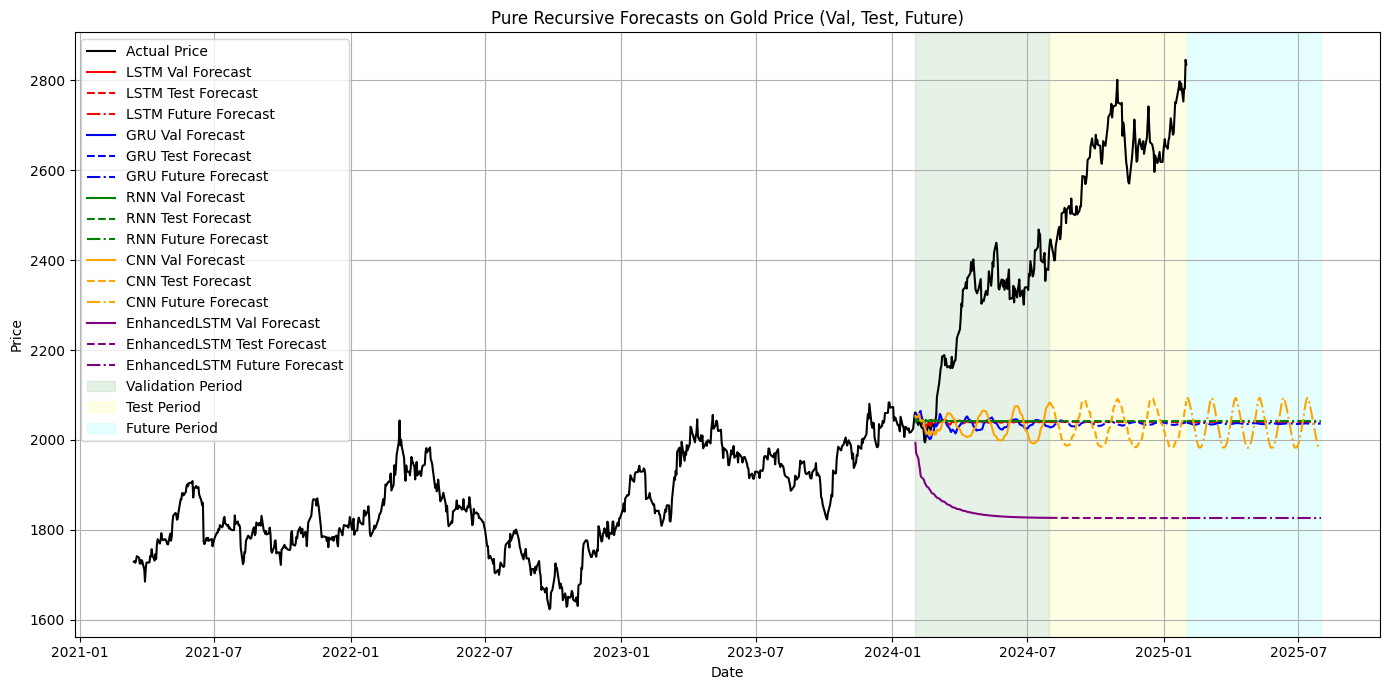

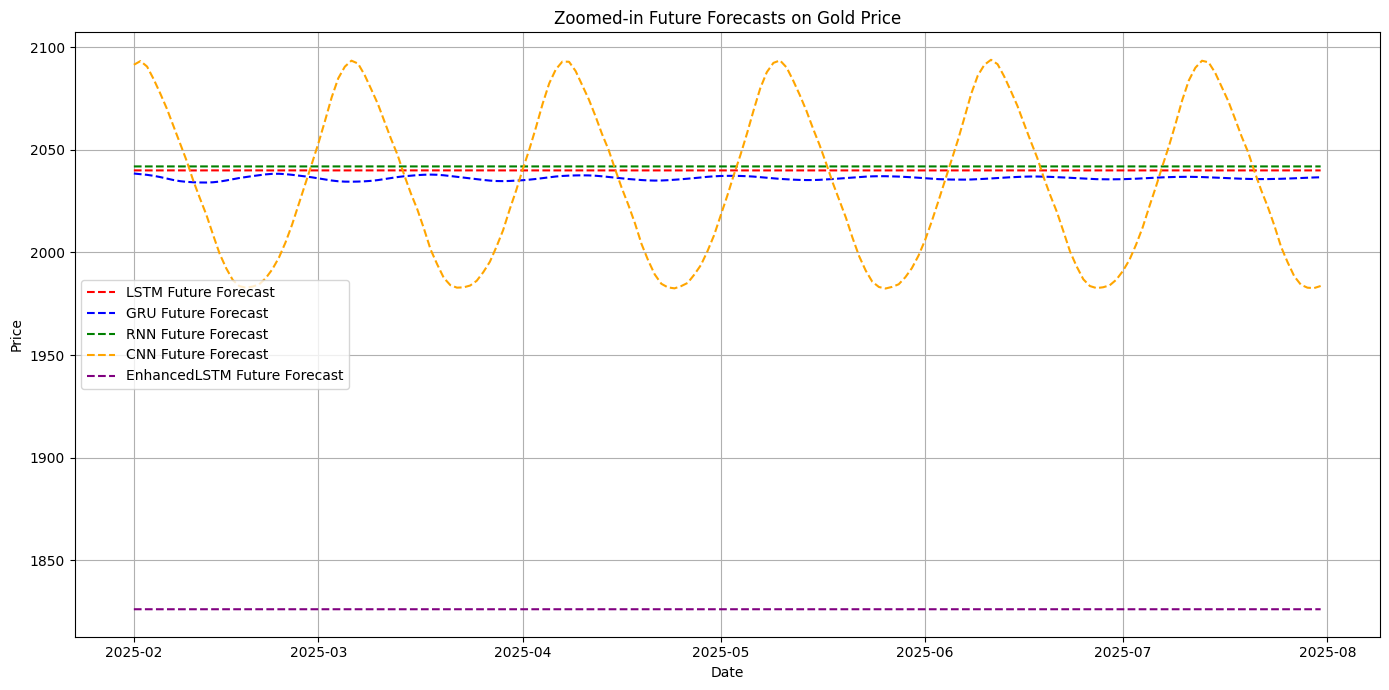

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # For activation functions
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import matplotlib.dates as mdates

# ------------------------------
# Set random seeds for reproducibility
# ------------------------------
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# ------------------------------
# Data Loading and Preparation
# ------------------------------
df = pd.read_csv('Gold Futures Historical Data_3Yr.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Transform numeric columns
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True)
df[num_cols] = df[num_cols].astype('float64')

# Check for duplicates and nulls
assert df.duplicated().sum() == 0, "Duplicate rows found!"
assert df.isnull().sum().sum() == 0, "Missing values found!"

# Define features and target
features = ['Price', 'Open', 'High', 'Low']
data = df[features].values

# Scale the data (each feature individually)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# ------------------------------
# Create Sequences (Sliding Window)
# ------------------------------
window_width = 30  # 30-day window

X, y, dates = [], [], []
for i in range(window_width, len(data_scaled)):
    X.append(data_scaled[i - window_width:i])
    y.append(data_scaled[i, 0])  # 'Price' is the target
    dates.append(df['Date'].iloc[i])

X = np.array(X)
y = np.array(y)
dates = np.array(dates)

assert len(dates) == len(y), "Mismatch between dates and y lengths"

# ------------------------------
# Split Data: Training, Validation, and Test
# ------------------------------
# (The actual dates are used only for error calculation and plotting.)
train_mask = dates < pd.to_datetime('2024-02-01')
val_mask   = (dates >= pd.to_datetime('2024-02-01')) & (dates < pd.to_datetime('2024-07-31'))
test_mask  = dates >= pd.to_datetime('2024-07-31')

# We now use only the training data for forming the seed window for recursive forecasting.
X_train, y_train = X[train_mask], y[train_mask]
# For evaluation purposes, we still keep the actual validation and test targets.
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

train_dates = dates[train_mask]
val_dates   = dates[val_mask]
test_dates  = dates[test_mask]

# ------------------------------
# Convert Data to PyTorch Tensors and Create DataLoaders (for training)
# ------------------------------
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
# (For training only, we use teacher forcing so we can use the actual windows.)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
batch_size = 32  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # Sequential data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------------------------------
# Define the Model
# ------------------------------
class BaseModel(nn.Module):
    def __init__(self, model_type='LSTM'):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                nonlinearity='relu',
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'CNN':
            self.conv1 = nn.Conv1d(in_channels=len(features), out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            conv_output_length = window_width - 2 * (3 - 1)  # after two conv layers
            self.fc = nn.Linear(128 * conv_output_length, 1)
        elif model_type == 'EnhancedLSTM':
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=128,
                num_layers=3,
                batch_first=True,
                dropout=0.2,
            )
            self.dropout = nn.Dropout(0.2)
            self.bn = nn.BatchNorm1d(128)
            self.fc = nn.Linear(128, 1)
        else:
            raise ValueError("Invalid model_type. Choose 'LSTM', 'GRU', 'RNN', 'CNN', or 'EnhancedLSTM'.")
    
    def forward(self, x):
        if self.model_type == 'CNN':
            x = x.permute(0, 2, 1)  # reshape for Conv1d: (batch, channels, sequence_length)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type == 'EnhancedLSTM':
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        else:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        return out

# ------------------------------
# Define Early Stopping
# ------------------------------
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# ------------------------------
# Inverse Transform Function
# ------------------------------
def inverse_transform(y_scaled):
    """
    Inverse transform the scaled 'Price' values back to the original scale.
    Assumes that the scaler was fit on all features.
    """
    y_scaled = np.array(y_scaled).reshape(-1, 1)
    zeros = np.zeros((y_scaled.shape[0], len(features) - 1))
    y_combined = np.hstack((y_scaled, zeros))
    y_inv = scaler.inverse_transform(y_combined)
    return y_inv[:, 0]

# ------------------------------
# Recursive Forecast Function
# ------------------------------
def recursive_forecast(model, seed_window, num_days, use_last_window_features=True):
    """
    Recursively forecast num_days ahead using the model.
    
    The model takes a window (of length window_width) as input.
    For each forecasted day, the new window is constructed by dropping the oldest row
    and appending a new row. If use_last_window_features is True, the new row is created
    by taking the non-target features from the last row of the current window, and replacing
    the target (Price) with the forecast; otherwise, non-target features are set to zero.
    """
    model.eval()
    current_window = seed_window.copy()  # shape: (window_width, num_features)
    forecasts = []
    for _ in range(num_days):
        # Prepare input (reshape to [1, window_width, num_features])
        input_tensor = torch.from_numpy(current_window).float().unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(input_tensor)
        pred_value = pred.cpu().numpy()[0, 0]  # scaled forecast for Price
        forecasts.append(pred_value)
        if use_last_window_features:
            # Copy non-target features from the last row; replace Price with the forecast.
            new_row = current_window[-1].copy()
            new_row[0] = pred_value
        else:
            new_row = np.zeros(current_window.shape[1])
            new_row[0] = pred_value
        # Update the window: drop the first row, append new_row at the end.
        current_window = np.vstack([current_window[1:], new_row])
    return np.array(forecasts)

# ------------------------------
# Train and Evaluate Function (Pure Recursive Forecasting)
# ------------------------------
def train_and_evaluate(model_name):
    # Initialize the model and send to device.
    model = BaseModel(model_type=model_name).to(device)
    
    # Loss, optimizer, and scheduler.
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=150)
    
    early_stopping = EarlyStopping(patience=150, min_delta=0)
    num_epochs = 1500
    best_val_loss = float('inf')
    
    train_losses_per_epoch = []
    val_losses_per_epoch = []
    
    best_model_path = f'best_model_{model_name}_3yr.pt'
    
    # Load saved model if available.
    if os.path.exists(best_model_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            model.load_state_dict(torch.load(best_model_path, map_location=device))
        print(f"Loaded existing model for {model_name} from {best_model_path}")
    
    # ----- Training (using teacher forcing on training data) -----
    for epoch in range(num_epochs):
        model.train()
        batch_losses = []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        avg_train_loss = np.mean(batch_losses)
        train_losses_per_epoch.append(avg_train_loss)
        
        # (We do not recursively forecast during training; validation/test evaluation is separate.)
        # For scheduling and early stopping we could use teacher-forced validation loss,
        # but here we focus on the recursive (pure) forecast evaluation.
        # If desired, you could compute a teacher-forced validation loss as well.
        
        scheduler.step(avg_train_loss)
        early_stopping(avg_train_loss)
        if early_stopping.early_stop:
            print(f"[{model_name}] Early stopping at epoch {epoch + 1}")
            break
        
        if avg_train_loss < best_val_loss:
            best_val_loss = avg_train_loss
            torch.save(model.state_dict(), best_model_path)
        
        if (epoch + 1) % 100 == 0:
            print(f'[{model_name}] Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.6f}')
    
    # Load best model weights.
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    
    # ----- Pure Recursive Forecasting for Validation, Test, and Future Periods -----
    # We start from the last training window (seed from X_train) and forecast forward.
    seed_window = X_train[-1]  # last window from training data
    horizon_val  = len(val_dates)
    horizon_test = len(test_dates)
    # Define future period dates (pure forecast beyond known data)
    future_dates = pd.date_range(start='2025-02-01', end='2025-07-31', freq='D')
    horizon_future = len(future_dates)
    
    total_horizon = horizon_val + horizon_test + horizon_future
    combined_forecast_scaled = recursive_forecast(model, seed_window, total_horizon, use_last_window_features=True)
    
    # Split the combined forecast into segments:
    val_preds_scaled    = combined_forecast_scaled[:horizon_val]
    test_preds_scaled   = combined_forecast_scaled[horizon_val : horizon_val + horizon_test]
    future_preds_scaled = combined_forecast_scaled[horizon_val + horizon_test :]
    
    # Inverse transform (to original price scale)
    val_preds_inv    = inverse_transform(val_preds_scaled)
    test_preds_inv   = inverse_transform(test_preds_scaled)
    future_preds_inv = inverse_transform(future_preds_scaled)
    
    # For error metrics we compare to the actual validation and test targets.
    val_mape = mean_absolute_percentage_error(y_val, val_preds_scaled)
    test_mape = mean_absolute_percentage_error(y_test, test_preds_scaled)
    print(f'[{model_name}] Pure Recursive Forecast - Validation MAPE: {val_mape*100:.2f}%')
    print(f'[{model_name}] Pure Recursive Forecast - Test MAPE: {test_mape*100:.2f}%')
    
    results = {
        'model_name': model_name,
        'val_dates': val_dates,
        'test_dates': test_dates,
        'future_dates': future_dates,
        'val_pred_inv': val_preds_inv,
        'test_pred_inv': test_preds_inv,
        'future_pred_inv': future_preds_inv,
        'train_losses_per_epoch': train_losses_per_epoch,
        'val_losses_per_epoch': val_losses_per_epoch,  # (if you add a validation loss computation)
    }
    return results

# ------------------------------
# Train and Evaluate All Models
# ------------------------------
model_names = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']
all_results = {}
for model_name in model_names:
    print(f"\nTraining {model_name} model...")
    results = train_and_evaluate(model_name)
    all_results[model_name] = results

# ------------------------------
# For Plotting Actual Prices (from the full dataset)
# ------------------------------
actual_prices = inverse_transform(y)

# Define colors for plotting
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
    'EnhancedLSTM': 'purple',
}

# ------------------------------
# Plot: Actual Price and Pure Recursive Forecasts (Validation, Test, Future)
# ------------------------------
plt.figure(figsize=(14, 7))
plt.plot(dates, actual_prices, color='black', label='Actual Price')

for model_name, results in all_results.items():
    # Plot validation forecasts
    plt.plot(results['val_dates'], results['val_pred_inv'],
             color=model_colors[model_name], linestyle='-', label=f'{model_name} Val Forecast')
    # Plot test forecasts
    plt.plot(results['test_dates'], results['test_pred_inv'],
             color=model_colors[model_name], linestyle='--', label=f'{model_name} Test Forecast')
    # Plot future forecasts
    plt.plot(results['future_dates'], results['future_pred_inv'],
             color=model_colors[model_name], linestyle='-.', label=f'{model_name} Future Forecast')

# Highlight periods
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')
plt.axvspan(pd.to_datetime('2025-02-01'), pd.to_datetime('2025-07-31'), color='cyan', alpha=0.1, label='Future Period')

plt.title('Pure Recursive Forecasts on Gold Price (Val, Test, Future)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------
# Optional: Zoomed-in Plot for Future Forecasts
# ------------------------------
plt.figure(figsize=(14, 7))
for model_name, results in all_results.items():
    plt.plot(results['future_dates'], results['future_pred_inv'],
             color=model_colors[model_name], linestyle='--', label=f'{model_name} Future Forecast')
plt.title('Zoomed-in Future Forecasts on Gold Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Training and evaluating model: LSTM
Early stopping triggered!
LSTM early stopping at epoch 48


/tmp/ipykernel_1182141/1148447638.py:219: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


LSTM Validation MAPE (Walk-Forward with Updates): 2.99%
LSTM Test MAPE (Walk-Forward with Updates): 3.60%

Training and evaluating model: GRU
GRU Epoch 50/300 | Train Loss: 0.000156 | Val Loss: 0.000272
GRU Epoch 100/300 | Train Loss: 0.000114 | Val Loss: 0.000343
Early stopping triggered!
GRU early stopping at epoch 109


/tmp/ipykernel_1182141/1148447638.py:219: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


GRU Validation MAPE (Walk-Forward with Updates): 2.46%
GRU Test MAPE (Walk-Forward with Updates): 3.11%


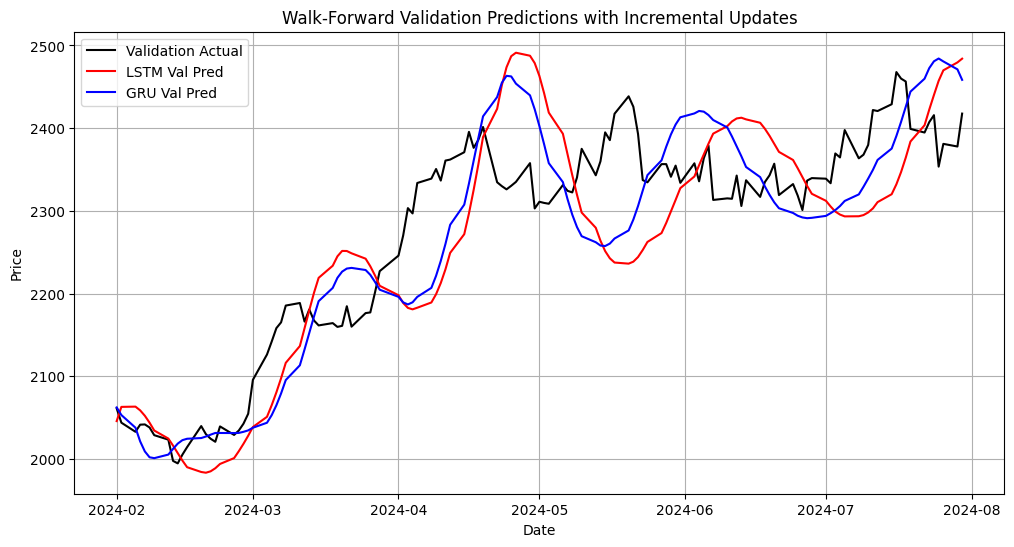

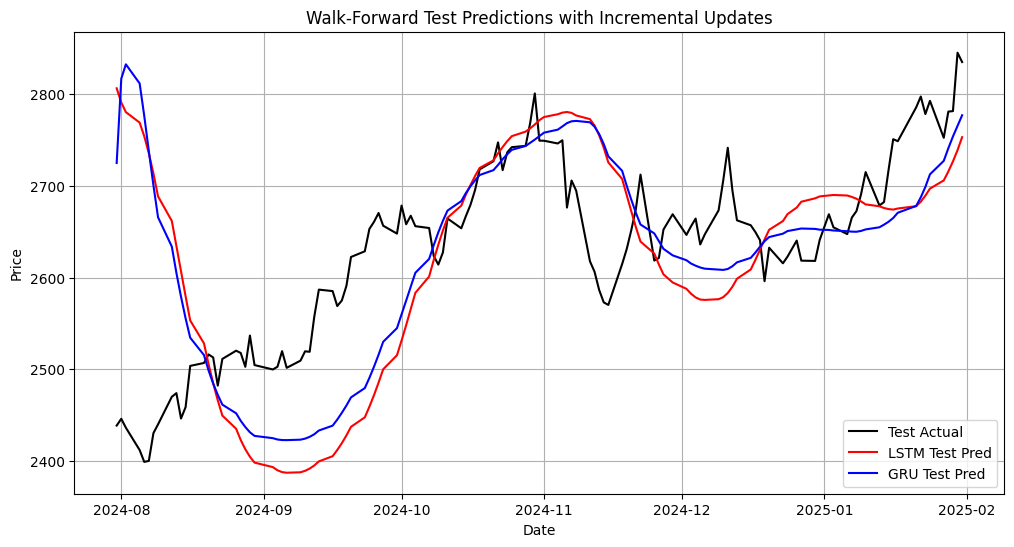

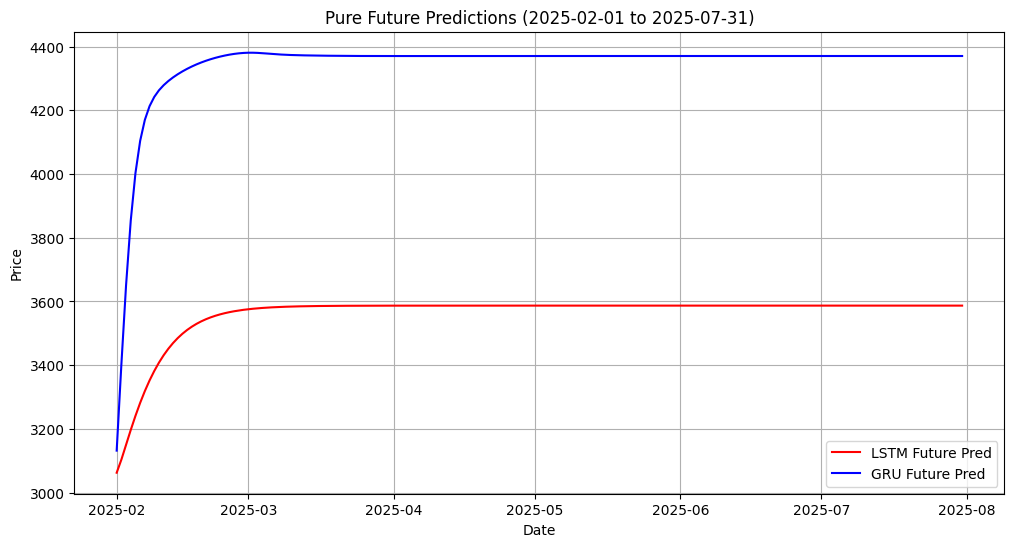

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import os
import random
import warnings

# -----------------------------
# 1) Reproducibility & Settings
# -----------------------------
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -----------------------------
# 2) Data Loading & Preprocessing
# -----------------------------
df = pd.read_csv('Gold Futures Historical Data_3Yr.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Remove commas and convert numeric columns
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True).astype('float64')
assert df.duplicated().sum() == 0, "Duplicate rows found!"
assert df.isnull().sum().sum() == 0, "Missing values found!"

# We use 4 features: Price, Open, High, Low.
features = ['Price', 'Open', 'High', 'Low']
data = df[features].values

# Scale all features to [0,1]
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

window_size = 30  # days per input window

# -----------------------------
# 3) Create Rolling Windows for Training
# -----------------------------
X_all = []
Y_all = []
dates_all = []

# For each window of 30 days, the target is the next day's Price (column 0)
for i in range(window_size, len(data_scaled)):
    X_all.append(data_scaled[i-window_size:i])
    Y_all.append(data_scaled[i, 0])
    dates_all.append(df['Date'].iloc[i])

X_all = np.array(X_all)  # shape (N, window_size, 4)
Y_all = np.array(Y_all)  # shape (N,)
dates_all = np.array(dates_all)

# -----------------------------
# 4) Train/Validation/Test Split by Date
# -----------------------------
train_cutoff = pd.to_datetime('2024-02-01')
val_cutoff   = pd.to_datetime('2024-07-31')

train_mask = dates_all < train_cutoff
val_mask   = (dates_all >= train_cutoff) & (dates_all < val_cutoff)
test_mask  = dates_all >= val_cutoff

X_train, Y_train, train_dates = X_all[train_mask], Y_all[train_mask], dates_all[train_mask]
X_val,   Y_val,   val_dates   = X_all[val_mask],   Y_all[val_mask],   dates_all[val_mask]
X_test,  Y_test,  test_dates  = X_all[test_mask],  Y_all[test_mask],  dates_all[test_mask]

# Convert training (and evaluation) data to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)
X_val_t   = torch.tensor(X_val, dtype=torch.float32)
Y_val_t   = torch.tensor(Y_val, dtype=torch.float32).unsqueeze(1)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
Y_test_t  = torch.tensor(Y_test, dtype=torch.float32).unsqueeze(1)

batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_t, Y_train_t), batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(TensorDataset(X_val_t, Y_val_t), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test_t, Y_test_t), batch_size=batch_size, shuffle=False)

# -----------------------------
# 5) Model Definitions
# -----------------------------
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=4, hidden_size=128, num_layers=2, dropout=0.1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # use output at last time step
        out = self.fc(out)
        return out

# GRU Model
class GRUModel(nn.Module):
    def __init__(self, input_size=4, hidden_size=128, num_layers=2, dropout=0.1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True,
                          dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out



# Dictionary to easily loop over models:
model_dict = {
    "LSTM": LSTMModel,
    "GRU": GRUModel,
}

# -----------------------------
# 6) Early Stopping
# -----------------------------
class EarlyStoppingSimple:
    def __init__(self, patience=30, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered!")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# -----------------------------
# 7) Inverse Transformation for Price
# -----------------------------
def inverse_price_transform(scaled_prices):
    """
    scaled_prices: numpy array (N,) or (N,1) of scaled Price values.
    We create dummy arrays for the other features to use the scaler's inverse_transform.
    """
    scaled_prices = scaled_prices.reshape(-1, 1)
    zeros = np.zeros((scaled_prices.shape[0], len(features) - 1))
    combined = np.hstack([scaled_prices, zeros])
    inv = scaler.inverse_transform(combined)
    return inv[:, 0]

# -----------------------------
# 8) Training Function for a Given Model
# -----------------------------
def train_model(model_class, model_name, train_loader, val_loader, epochs=300, lr=0.0005, patience=30):
    model = model_class().to(device)
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=patience)
    early_stopping = EarlyStoppingSimple(patience=patience, min_delta=0.0)
    
    best_val_loss = float('inf')
    best_model_path = f'best_{model_name}_model.pt'
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for Xb, Yb in train_loader:
            Xb, Yb = Xb.to(device), Yb.to(device)
            optimizer.zero_grad()
            preds = model(Xb)
            loss = criterion(preds, Yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        
        model.eval()
        val_losses = []
        with torch.no_grad():
            for Xb, Yb in val_loader:
                Xb, Yb = Xb.to(device), Yb.to(device)
                preds = model(Xb)
                loss = criterion(preds, Yb)
                val_losses.append(loss.item())
        avg_val_loss = np.mean(val_losses)
        scheduler.step(avg_val_loss)
        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print(f"{model_name} early stopping at epoch {epoch+1}")
            break
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
        if (epoch+1) % 50 == 0:
            print(f"{model_name} Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    return model

# -----------------------------
# 9) Walk-Forward Forecasting with Incremental Updates
# -----------------------------
def walk_forward_with_updates(model, data_scaled, dates, start_idx, end_idx, window=30, epochs_per_update=1, lr=1e-4):
    """
    Walk-forward forecast (pure prediction) from start_idx to end_idx.
    After predicting day t, perform a small incremental update (online update)
    using the actual value (available only in validation and test periods).
    """
    inc_optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    
    model.eval()
    preds_scaled = []
    actual_scaled = []
    forecast_dates = []
    
    # Initialize the input window using the last 'window' days before start_idx.
    current_window = data_scaled[start_idx-window : start_idx].copy()
    
    for t in range(start_idx, end_idx):
        X_in = torch.tensor(current_window, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            y_pred_t = model(X_in).cpu().numpy().flatten()[0]
        preds_scaled.append(y_pred_t)
        forecast_dates.append(dates[t])
        
        # Record the actual scaled Price for day t.
        y_true_t = data_scaled[t, 0]
        actual_scaled.append(y_true_t)
        
        # Shift the window: drop the oldest day, append new row.
        # For new row, we use the predicted Price for all features (since no extra info available).
        # New approach: update only the Price column while preserving Open, High, and Low from the last row.
        current_window = current_window[1:]
        last_row = current_window[-1].copy()  # last row of the current window
        new_row = last_row.copy()
        new_row[0] = y_pred_t  # update only the Price
        current_window = np.vstack([current_window, new_row])

        
        # Incremental online update: use the input window (X_in) and actual y_true_t.
        X_update = X_in  # (1, window, 4)
        Y_update = torch.tensor([[y_true_t]], dtype=torch.float32).to(device)
        model.train()
        for _ in range(epochs_per_update):
            inc_optimizer.zero_grad()
            y_update_pred = model(X_update)
            update_loss = loss_fn(y_update_pred, Y_update)
            update_loss.backward()
            inc_optimizer.step()
        model.eval()
    
    return np.array(preds_scaled), np.array(actual_scaled), np.array(forecast_dates)

# -----------------------------
# 10) Pure Recursive Forecasting for Future Predictions
# -----------------------------
def recursive_forecast_future(model, seed_window, horizon, window=30):
    """
    Forecast pure future predictions (without online updates).
    seed_window: numpy array of shape (window, 4) used as initial input.
    horizon: number of days to forecast.
    """
    model.eval()
    current_window = seed_window.copy()
    preds = []
    for _ in range(horizon):
        X_in = torch.tensor(current_window, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            y_pred = model(X_in).cpu().numpy().flatten()[0]
        preds.append(y_pred)
        # Update window: drop the oldest row, append new row with predicted Price (replicated for all features)
        current_window = current_window[1:]
        new_row = current_window[-1].copy()  # or simply replicate y_pred
        new_row = np.array([y_pred] * 4)
        current_window = np.vstack([current_window, new_row])
    return np.array(preds)

# -----------------------------
# 11) Train & Evaluate All Models and Forecast Future
# -----------------------------
results_all = {}  # dictionary to store results for each model
# We also need the full data and dates arrays.
data_scaled_full = data_scaled  # shape (N,4)
dates_full = df['Date'].values   # shape (N,)

# Get indices for validation and test from the full data
val_start_idx = np.where(dates_full == val_dates[0])[0][0]
val_end_idx   = np.where(dates_full == val_dates[-1])[0][0] + 1
test_start_idx = np.where(dates_full == test_dates[0])[0][0]
test_end_idx   = np.where(dates_full == test_dates[-1])[0][0] + 1

# Define the Future mask period: 2025-02-01 to 2025-07-31.
future_dates = pd.date_range(start='2025-02-01', end='2025-07-31', freq='D')
horizon_future = len(future_dates)

for model_name, model_class in model_dict.items():
    print(f"\nTraining and evaluating model: {model_name}")
    # Train model on training data (using teacher forcing)
    trained_model = train_model(model_class, model_name, train_loader, val_loader, epochs=300, lr=0.0005, patience=30)
    
    # Walk-forward forecasting on Validation and Test sets with incremental updates.
    val_preds_scaled, val_actual_scaled, val_forecast_dates = walk_forward_with_updates(
        trained_model, data_scaled_full, dates_full,
        start_idx=val_start_idx,
        end_idx=val_end_idx,
        window=window_size,
        epochs_per_update=1,
        lr=1e-4
    )
    test_preds_scaled, test_actual_scaled, test_forecast_dates = walk_forward_with_updates(
        trained_model, data_scaled_full, dates_full,
        start_idx=test_start_idx,
        end_idx=test_end_idx,
        window=window_size,
        epochs_per_update=1,
        lr=1e-4
    )
    
    # For future predictions, we use a pure recursive forecast.
    # Use the last available window from the full dataset as seed.
    seed_window = data_scaled_full[-window_size:].copy()  # shape (window,4)
    future_preds_scaled = recursive_forecast_future(trained_model, seed_window, horizon_future, window=window_size)
    
    # Inverse-transform the predictions and actual values.
    val_preds_inv = inverse_price_transform(val_preds_scaled)
    test_preds_inv = inverse_price_transform(test_preds_scaled)
    future_preds_inv = inverse_price_transform(future_preds_scaled)
    
    # Compute error metrics for validation and test.
    val_mape = mean_absolute_percentage_error(inverse_price_transform(val_actual_scaled), val_preds_inv) * 100
    test_mape = mean_absolute_percentage_error(inverse_price_transform(test_actual_scaled), test_preds_inv) * 100
    print(f"{model_name} Validation MAPE (Walk-Forward with Updates): {val_mape:.2f}%")
    print(f"{model_name} Test MAPE (Walk-Forward with Updates): {test_mape:.2f}%")
    
    results_all[model_name] = {
        "val_forecast_dates": val_forecast_dates,
        "val_preds_inv": val_preds_inv,
        "val_actual_inv": inverse_price_transform(val_actual_scaled),
        "test_forecast_dates": test_forecast_dates,
        "test_preds_inv": test_preds_inv,
        "test_actual_inv": inverse_price_transform(test_actual_scaled),
        "future_forecast_dates": future_dates,
        "future_preds_inv": future_preds_inv,
    }

# -----------------------------
# 12) Plotting Results
# -----------------------------
import matplotlib.dates as mdates

# Plot Validation Forecasts for each model
plt.figure(figsize=(12,6))
plt.plot(val_forecast_dates, inverse_price_transform(val_actual_scaled), label='Validation Actual', color='black')
colors = {"LSTM": "red", "GRU": "blue"}
for model_name, res in results_all.items():
    plt.plot(res["val_forecast_dates"], res["val_preds_inv"], label=f'{model_name} Val Pred', color=colors.get(model_name, "gray"))
plt.title("Walk-Forward Validation Predictions with Incremental Updates")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# Plot Test Forecasts for each model
plt.figure(figsize=(12,6))
plt.plot(test_forecast_dates, inverse_price_transform(test_actual_scaled), label='Test Actual', color='black')
for model_name, res in results_all.items():
    plt.plot(res["test_forecast_dates"], res["test_preds_inv"], label=f'{model_name} Test Pred', color=colors.get(model_name, "gray"))
plt.title("Walk-Forward Test Predictions with Incremental Updates")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# Plot Future Forecasts (Pure predictions from 2025-02-01 to 2025-07-31)
plt.figure(figsize=(12,6))
for model_name, res in results_all.items():
    plt.plot(res["future_forecast_dates"], res["future_preds_inv"], label=f'{model_name} Future Pred', color=colors.get(model_name, "gray"))
plt.title("Pure Future Predictions (2025-02-01 to 2025-07-31)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipykernel_1016168/759521126.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))
/tmp/ipykernel_

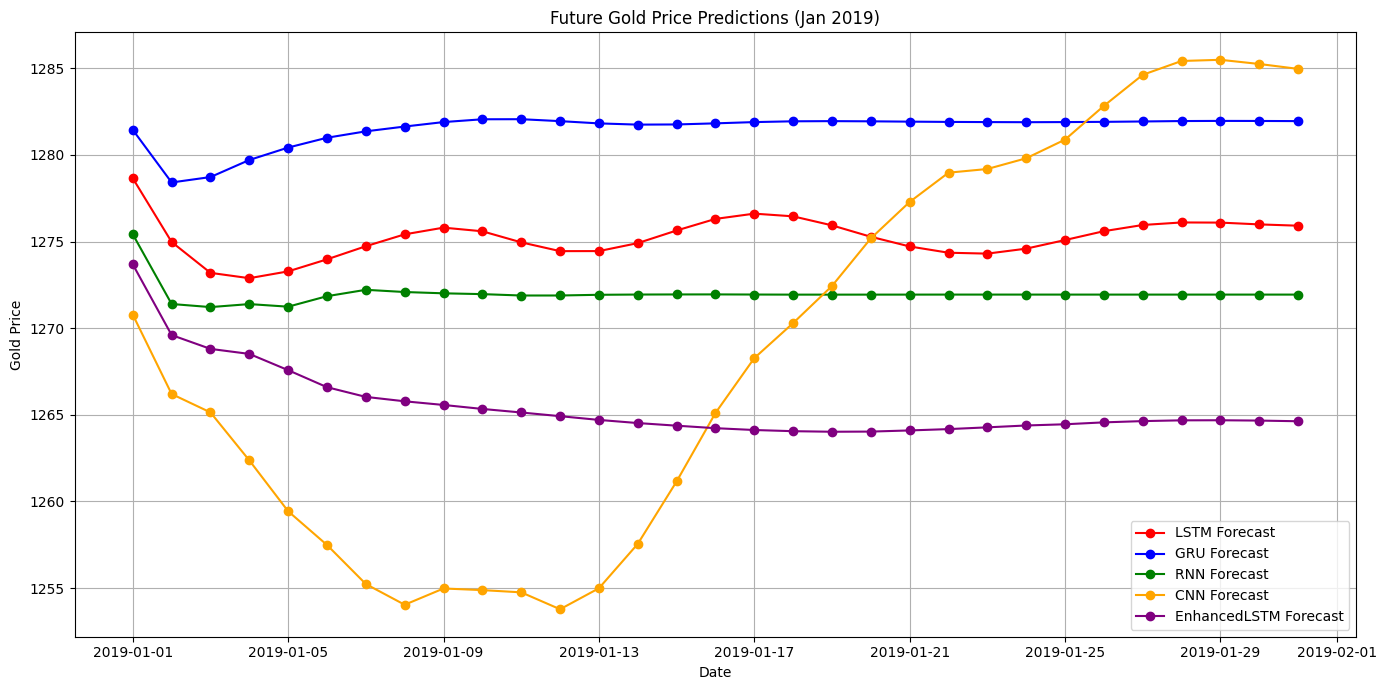

In [3]:
###############################################
# Future Prediction: Forecasting Gold Price
# for the period 2019-01-01 to 2019-01-31
###############################################

# Dictionary to store the forecasted prices (in original scale) for each model
future_forecasts = {}

# Define the forecast period: January 1 to January 31, 2019
future_dates = pd.date_range(start='2019-01-01', end='2019-01-31', freq='D')

# For each model, load the saved best checkpoint and perform iterative forecasting
for model_name in model_names:
    # Initialize the model and load the best saved weights
    model = BaseModel(model_type=model_name).to(device)
    best_model_path = f'best_model_{model_name}.pt'
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.eval()
    
    # Start with the last available window from the entire historical dataset
    # (Make a copy so that the original data_scaled remains unchanged)
    forecast_window = data_scaled[-window_width:].copy()  # shape: (window_width, n_features)
    
    # List to store the scaled predictions (for the target 'Price')
    forecast_preds = []
    
    # Disable gradient tracking for forecasting
    with torch.no_grad():
        # Iterate for each day in the forecast period (31 days)
        for _ in range(len(future_dates)):
            # Prepare the input: add batch dimension (shape: [1, window_width, n_features])
            input_tensor = torch.from_numpy(forecast_window).unsqueeze(0).float().to(device)
            
            # Obtain the prediction (scaled price)
            pred = model(input_tensor)
            pred_value = pred.item()  # scalar value
            
            # Append the predicted scaled price to our list
            forecast_preds.append(pred_value)
            
            # Update the forecast window:
            # Create a new row based on the last row of the current window.
            # Replace only the 'Price' column (index 0) with the predicted value.
            new_row = forecast_window[-1].copy()
            new_row[0] = pred_value
            # Roll the window: remove the oldest row and append the new row at the end
            forecast_window = np.vstack((forecast_window[1:], new_row))
    
    # Inverse transform the list of scaled predictions back to the original scale.
    # (The inverse_transform function only uses the first column, so it works for our list.)
    forecast_preds_inv = inverse_transform(forecast_preds)
    
    # Store the forecasted prices for this model
    future_forecasts[model_name] = forecast_preds_inv

# Plot the future forecasted prices for each model
plt.figure(figsize=(14, 7))
for model_name, preds in future_forecasts.items():
    plt.plot(future_dates, preds, color=model_colors[model_name], linestyle='-', marker='o',
             label=f'{model_name} Forecast')

plt.title('Future Gold Price Predictions (Jan 2019)')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_1016168/1552756690.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  future_model.load_state_dict(torch.load(best_model_path, map_location=device))


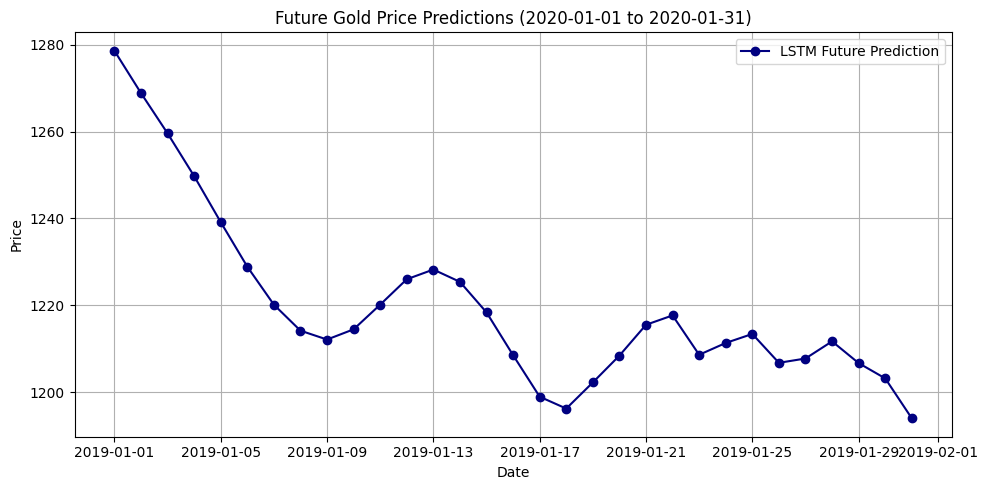

         Date  Predicted Price
0  2019-01-01      1278.654784
1  2019-01-02      1268.891180
2  2019-01-03      1259.614430
3  2019-01-04      1249.757114
4  2019-01-05      1239.153828
5  2019-01-06      1228.883743
6  2019-01-07      1220.127108
7  2019-01-08      1214.140468
8  2019-01-09      1212.092611
9  2019-01-10      1214.447813
10 2019-01-11      1220.138146
11 2019-01-12      1225.989377
12 2019-01-13      1228.223902
13 2019-01-14      1225.387136
14 2019-01-15      1218.350639
15 2019-01-16      1208.487197
16 2019-01-17      1198.917020
17 2019-01-18      1196.183732
18 2019-01-19      1202.208063
19 2019-01-20      1208.395549
20 2019-01-21      1215.495852
21 2019-01-22      1217.652994
22 2019-01-23      1208.581221
23 2019-01-24      1211.306849
24 2019-01-25      1213.379664
25 2019-01-26      1206.731009
26 2019-01-27      1207.722706
27 2019-01-28      1211.673069
28 2019-01-29      1206.660913
29 2019-01-30      1203.141854
30 2019-01-31      1193.933780


In [2]:
# ------------------------------
# Future Prediction: 2020-01-01 to 2020-01-31
# ------------------------------

# Choose the model to use for forecasting (e.g., 'LSTM')
future_model_name = 'LSTM'
best_model_path = f'best_model_{future_model_name}.pt'

# Initialize and load the trained model
future_model = BaseModel(model_type=future_model_name).to(device)
future_model.load_state_dict(torch.load(best_model_path, map_location=device))
future_model.eval()

# Create a date range for the future period
start_date = pd.to_datetime('2019-01-01')
end_date = pd.to_datetime('2019-01-31')
future_dates = pd.date_range(start_date, end_date)

# Use the last available window from the scaled data as the starting point
# Note: 'data_scaled' is from the full dataset used in training
current_window = data_scaled[-window_width:].copy()  # shape: (window_width, num_features)

future_predictions_scaled = []  # To store the model's scaled predictions

# Rolling forecast: predict one day ahead at a time
for future_date in future_dates:
    # Prepare the current window as input (add batch dimension)
    input_tensor = torch.from_numpy(current_window).float().unsqueeze(0).to(device)  # shape: (1, window_width, num_features)
    
    with torch.no_grad():
        pred_scaled = future_model(input_tensor).cpu().numpy()[0, 0]  # Get scalar prediction
    future_predictions_scaled.append(pred_scaled)
    
    # Create a new row for the predicted day.
    # Since the model was trained on 4 features, we fill Open, High, Low with the same value as Price.
    new_row = np.array([pred_scaled, pred_scaled, pred_scaled, pred_scaled])
    
    # Append the new prediction to the window and drop the oldest row to maintain the window length
    current_window = np.vstack([current_window[1:], new_row])

# Inverse transform the scaled predictions back to the original price scale
future_predictions = inverse_transform(future_predictions_scaled)

# Plot the future predictions
plt.figure(figsize=(10, 5))
plt.plot(future_dates, future_predictions, marker='o', linestyle='-', color='navy', label=f'{future_model_name} Future Prediction')
plt.title('Future Gold Price Predictions (2020-01-01 to 2020-01-31)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the predictions as a DataFrame
future_df = pd.DataFrame({'Date': future_dates, 'Predicted Price': future_predictions})
print(future_df)
